## Логистическая регрессия

In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Вопросы

При выполнении задания возникло несколько вопроса:
1. В наших лекциях функция log loss задается в виде $$ Q(\theta) = - \frac{1}{m}\sum_{i=1}^{m}(y_i \log (\sigma(\theta^Tx)) + (1-y_i)log(1-\sigma(\theta^Tx))),$$
а у Воронцова (http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) $$ Q(\theta) = \sum_{i=1}^{m}ln(1+e^{-y_i\theta^Tx}) $$
Праивльно ли я понимаю, что это одно и то же в зависимости от  того, как мы обозначаем метки кластеров? У нас это было 1 и 0, а у него это 1 и -1 (у нас еще усредняется по всей выборки, но это, я так понимаю, не принципиально)

2. коэффициент C при регуляризации, это именно коэффициент регуляризации, т.е. то, что стоит перед аддитивной состоявляющей в формуле log loss или это обратный коэффициент регуляризации, который стоит перед основным слагаемым функции log loss?

3. При использовании L1 регуляризации, разделяющая прямая, какая-то совсем не разделяющая. Это косяк алгоритма?

4. Регуляризация часто используется для устранения эффекта переобучения. А как выглядит переобучение в случае использования для разделения классов прямой (или гиперплоскости) - $\theta^Tx$. Как оно (переобучение) выглядит при использовании кривых (поверхностей) 2 и более порядка я понимаю (кривая "старается" пройти через все наблюдения), а как это выглядит в случае с прямой? Это я к тому, что уместно, вообще, использовать регуляризацию при линейной функции разделения?
5. При SGD, если мы хотим считать ошибка после каждой итерации (после каждого изменения весов), мы долдны ее считать по всей выборки? 

Спасибо

In [368]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
     
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.w = np.random.randn(3)/10
        
    #Логистическая функция
    def logist_func (self, z):        
        return 1/(1 + np.exp(-z))
    
    #Подсчет эмпирического риска для одного наблюдения 
    def log_loss_for_one (self, x_i, y_i, w):
        return y_i*np.log(self.logist_func(self.w.T.dot(x_i))) + (1 - y_i)*(np.log(1 - self.logist_func(self.w.T.dot(x_i))))
          
    #Вычисление эмперического риска для всей выборки    
    def log_loss (self, X_with_one, y, w, regul):
        error = 0
        m = len(X)
        for i in range(m):
            x_i = X_with_one[i, :]
            y_i = y[i]            
            error = error + self.log_loss_for_one(x_i, y_i, w)
        if regul is None: Q = -error/m
        elif regul == 'L2': Q = -error/m + self.C*(w[1:]**2).sum()
        elif regul == 'L1': Q = -error/m + self.C*np.abs(w[1:]).sum()
        return Q
        
    #Вычисление градиента эмпирическго риска
    def grad_log_loss (self, x, y, w, regul):
        if regul is None: return (self.logist_func(w.T.dot(x)) - y)*x
        elif regul == 'L2': return (self.logist_func(w.T.dot(x)) - y)*x + self.C*np.array([0, w[1], w[2]])
        elif regul == 'L1': return (self.logist_func(w.T.dot(x)) - y)*x + self.C*np.sign(np.array([0, w[1], w[2]]))
        
   
    def fit(self, X, y=None, regul=None, err_by_iter=True):
        '''
        Обучение модели
        '''
        X_with_one = np.hstack([np.ones(X.shape[0]).reshape(X.shape[0], 1), X])        
        m = X_with_one.shape[0]
        error_epoch_list = list()
        error_iter_list = list()
        w_list = list([self.w])
        for epoch in range(self.max_epoch):
            #p = np.random.permutation(m)
            for i in range(m):
                idx = np.random.randint(m)
                x_i = X_with_one[idx, :]
                y_i = y[idx] 
                gradient = self.grad_log_loss(x_i, y_i, self.w, regul)
                self.w = self.w - self.alpha * gradient
                if err_by_iter:
                    error_iter = self.log_loss(X_with_one, y, self.w, regul)
                    print('Эпоха #{}. Ошибка: {}'.format(epoch+1, error_iter))
                    error_iter_list.append(error_iter)
           
            error_epoch = self.log_loss(X_with_one, y, self.w, regul)   
            error_epoch_list.append(error_epoch)
                      
            w_list.append(self.w)            
        return self.w, w_list, error_epoch_list, error_iter_list
    
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''    
        return self
        
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat_proba = self.predict_proba(X)
        if y_hat_proba[0]>y_hat_proba[1]: y_hat = 1
        else: y_hat = 0            
        return y_hat
    
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        p_plus = self.logist_func(self.w.T.dot(np.hstack([np.ones(1),X])))
        y_hat_proba = (p_plus, 1-p_plus)        
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [362]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

In [363]:
np.hstack([X,y.reshape(y.shape[0],1)])

array([[ 5.10023581, -2.69111611,  1.        ],
       [ 7.8613398 , -0.59027583,  1.        ],
       [ 3.03408318, -3.8758687 ,  1.        ],
       ..., 
       [-1.1568567 , -1.07797884,  0.        ],
       [-0.57961173, -1.85617983,  0.        ],
       [-0.5845925 , -1.33371091,  0.        ]])

In [364]:
def get_line(w, x):
    return w[0]/w[1] - w[2]*x/w[1]

In [365]:
def draw_graph(X, w, w_list, error_epoch_list, error_iter_list, title):
    plt.figure(figsize=(25,10))
    plt.subplot(131)
    plt.scatter(X[:,0], X[:,1], c=y)
    x_line = np.array([-2, 8])
    for w1 in w_list:
        plt.plot(x_line, get_line(w1, x_line), 'r--')
    plt.plot(x_line, get_line(w, x_line),'g-', linewidth=2.0)
    plt.title(title)
    plt.xlabel("$x_1$", fontsize=14)                     
    plt.ylabel("$x_2$", rotation=0, fontsize=14) 
    plt.subplot(132)
    plt.title('Error by epochs')
    plt.xlabel("Epochs", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14) 
    plt.plot(np.linspace(1, len(error_epoch_list), len(error_epoch_list)), error_epoch_list)
    plt.subplot(133)
    plt.title('Error by iterations')
    plt.xlabel("Iterations", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14)     
    plt.plot(np.linspace(1, len(error_iter_list)*X.shape[0], len(error_iter_list)), error_iter_list)
    plt.show()

In [369]:
model = MySGDClassifier(C=.1, alpha=0.01, max_epoch=10)
w_nan, w_list_nan, error_epoch_list_nan, error_iter_list_nan = model.fit(X, y, err_by_iter=True)
print('Без регуляризации:')
print('Веса: {}. Минимальная ошибка: {}'.format(w_nan, error_epoch_list_nan[len(error_epoch_list_nan)-1]))

Эпоха #1. Ошибка: 0.6828067333292513
Эпоха #1. Ошибка: 0.6605075148353784
Эпоха #1. Ошибка: 0.6709779519345486
Эпоха #1. Ошибка: 0.6571369801209725
Эпоха #1. Ошибка: 0.650668380207885
Эпоха #1. Ошибка: 0.6383591143136536
Эпоха #1. Ошибка: 0.6279986059744281
Эпоха #1. Ошибка: 0.6339306949119502
Эпоха #1. Ошибка: 0.6210111683071488
Эпоха #1. Ошибка: 0.6278208118852145
Эпоха #1. Ошибка: 0.6260733553524334
Эпоха #1. Ошибка: 0.6212384513870501
Эпоха #1. Ошибка: 0.6126297449857168
Эпоха #1. Ошибка: 0.6170194387358899
Эпоха #1. Ошибка: 0.6160089624700887
Эпоха #1. Ошибка: 0.6174426141248909
Эпоха #1. Ошибка: 0.6104506683100311
Эпоха #1. Ошибка: 0.6067695390304501
Эпоха #1. Ошибка: 0.6068707982316046
Эпоха #1. Ошибка: 0.6193569778810604
Эпоха #1. Ошибка: 0.6161181886478992
Эпоха #1. Ошибка: 0.6060316792548597
Эпоха #1. Ошибка: 0.600988486201928
Эпоха #1. Ошибка: 0.5994826396849584
Эпоха #1. Ошибка: 0.5934933156725974
Эпоха #1. Ошибка: 0.5938723373966571
Эпоха #1. Ошибка: 0.5892181533409421
Эпо

Эпоха #1. Ошибка: 0.5570948603131637
Эпоха #1. Ошибка: 0.5528377226542396
Эпоха #1. Ошибка: 0.5519122026840325
Эпоха #1. Ошибка: 0.5506092269190939
Эпоха #1. Ошибка: 0.5520348842824455
Эпоха #1. Ошибка: 0.5536414230287096
Эпоха #1. Ошибка: 0.5526528329363363
Эпоха #1. Ошибка: 0.5521691941554218
Эпоха #1. Ошибка: 0.5548309027010905
Эпоха #1. Ошибка: 0.5568654773577281
Эпоха #1. Ошибка: 0.5585155133811187
Эпоха #1. Ошибка: 0.5607148031686151
Эпоха #1. Ошибка: 0.5567173977245004
Эпоха #1. Ошибка: 0.5595429875764808
Эпоха #1. Ошибка: 0.5618862843396568
Эпоха #1. Ошибка: 0.5607059141286768
Эпоха #1. Ошибка: 0.5604176166336776
Эпоха #1. Ошибка: 0.5541804470337763
Эпоха #1. Ошибка: 0.5562670197090829
Эпоха #1. Ошибка: 0.5585008717890889
Эпоха #1. Ошибка: 0.5588686728540732
Эпоха #1. Ошибка: 0.5608223183617023
Эпоха #1. Ошибка: 0.5629027409654102
Эпоха #1. Ошибка: 0.5591443984622412
Эпоха #1. Ошибка: 0.5607604525337208
Эпоха #1. Ошибка: 0.5591024400706117
Эпоха #1. Ошибка: 0.5552886983572162
Э

Эпоха #2. Ошибка: 0.5083468940223579
Эпоха #2. Ошибка: 0.5085698540424518
Эпоха #2. Ошибка: 0.509235922399971
Эпоха #2. Ошибка: 0.5098091867381631
Эпоха #2. Ошибка: 0.5106849296538709
Эпоха #2. Ошибка: 0.5083774467789135
Эпоха #2. Ошибка: 0.5089267738766988
Эпоха #2. Ошибка: 0.5101571714791386
Эпоха #2. Ошибка: 0.5097341487007621
Эпоха #2. Ошибка: 0.5109778958319281
Эпоха #2. Ошибка: 0.5080760487542484
Эпоха #2. Ошибка: 0.5077024839891943
Эпоха #2. Ошибка: 0.5076649206127144
Эпоха #2. Ошибка: 0.5081394910487403
Эпоха #2. Ошибка: 0.5080741316495498
Эпоха #2. Ошибка: 0.5076934978596869
Эпоха #2. Ошибка: 0.5082491361556895
Эпоха #2. Ошибка: 0.5082424660222372
Эпоха #2. Ошибка: 0.5073287517322757
Эпоха #2. Ошибка: 0.507998400082032
Эпоха #2. Ошибка: 0.5072353339389132
Эпоха #2. Ошибка: 0.5065274578198732
Эпоха #2. Ошибка: 0.5071199377426829
Эпоха #2. Ошибка: 0.5076690215800552
Эпоха #2. Ошибка: 0.5073764989136705
Эпоха #2. Ошибка: 0.5068301914232329
Эпоха #2. Ошибка: 0.5069198415742183
Эпо

Эпоха #2. Ошибка: 0.4854967051308631
Эпоха #2. Ошибка: 0.4838226896109012
Эпоха #2. Ошибка: 0.48374261065937085
Эпоха #2. Ошибка: 0.4822969457778948
Эпоха #2. Ошибка: 0.48193836177780397
Эпоха #2. Ошибка: 0.48169270984562196
Эпоха #2. Ошибка: 0.4816224488742006
Эпоха #2. Ошибка: 0.4817576166581883
Эпоха #2. Ошибка: 0.4813250421619827
Эпоха #2. Ошибка: 0.4813240476430481
Эпоха #2. Ошибка: 0.48134214970247946
Эпоха #2. Ошибка: 0.4817400017607638
Эпоха #2. Ошибка: 0.48250600679930095
Эпоха #2. Ошибка: 0.4835419953900047
Эпоха #2. Ошибка: 0.48430464777883925
Эпоха #2. Ошибка: 0.48436612531213996
Эпоха #2. Ошибка: 0.48546793227691354
Эпоха #2. Ошибка: 0.4871821829881114
Эпоха #2. Ошибка: 0.48921827565923415
Эпоха #2. Ошибка: 0.4910118677792212
Эпоха #2. Ошибка: 0.4903585873976046
Эпоха #2. Ошибка: 0.49159429868340737
Эпоха #2. Ошибка: 0.4930646339772521
Эпоха #2. Ошибка: 0.4926124303211622
Эпоха #2. Ошибка: 0.4880463973174705
Эпоха #2. Ошибка: 0.4896920397606076
Эпоха #2. Ошибка: 0.48991031

Эпоха #3. Ошибка: 0.4733115118294773
Эпоха #3. Ошибка: 0.47340130325236146
Эпоха #3. Ошибка: 0.47560319798027445
Эпоха #3. Ошибка: 0.46660970633340654
Эпоха #3. Ошибка: 0.46540581837093326
Эпоха #3. Ошибка: 0.4652847016879123
Эпоха #3. Ошибка: 0.4645578314717583
Эпоха #3. Ошибка: 0.46308738750297024
Эпоха #3. Ошибка: 0.4629348092941533
Эпоха #3. Ошибка: 0.46285638920684485
Эпоха #3. Ошибка: 0.4628036761800744
Эпоха #3. Ошибка: 0.46219823634250157
Эпоха #3. Ошибка: 0.46147284810667677
Эпоха #3. Ошибка: 0.461900875909676
Эпоха #3. Ошибка: 0.4618870526906187
Эпоха #3. Ошибка: 0.46264943928288405
Эпоха #3. Ошибка: 0.46163171176084533
Эпоха #3. Ошибка: 0.4615656868811246
Эпоха #3. Ошибка: 0.4613867638924305
Эпоха #3. Ошибка: 0.46145699096873694
Эпоха #3. Ошибка: 0.4616421641266193
Эпоха #3. Ошибка: 0.4616817636846814
Эпоха #3. Ошибка: 0.4617744689617727
Эпоха #3. Ошибка: 0.461364371746997
Эпоха #3. Ошибка: 0.46128243933975815
Эпоха #3. Ошибка: 0.4618696176534885
Эпоха #3. Ошибка: 0.46094064

Эпоха #3. Ошибка: 0.4449401199352429
Эпоха #3. Ошибка: 0.4449349050884834
Эпоха #3. Ошибка: 0.4452291955416364
Эпоха #3. Ошибка: 0.445269322506821
Эпоха #3. Ошибка: 0.4458646390451092
Эпоха #3. Ошибка: 0.4468137294696319
Эпоха #3. Ошибка: 0.44767163703780993
Эпоха #3. Ошибка: 0.447765272973908
Эпоха #3. Ошибка: 0.4479690713901562
Эпоха #3. Ошибка: 0.44810050902969883
Эпоха #3. Ошибка: 0.44940533603137106
Эпоха #3. Ошибка: 0.4503857547513261
Эпоха #3. Ошибка: 0.45061778854497786
Эпоха #3. Ошибка: 0.44898400856605214
Эпоха #3. Ошибка: 0.45067598003123577
Эпоха #3. Ошибка: 0.4498279444995676
Эпоха #3. Ошибка: 0.4510728993642952
Эпоха #3. Ошибка: 0.4459816527537329
Эпоха #3. Ошибка: 0.44713917067270514
Эпоха #3. Ошибка: 0.4479250527066608
Эпоха #3. Ошибка: 0.4453322803032981
Эпоха #3. Ошибка: 0.44642439570947895
Эпоха #3. Ошибка: 0.4473117054324338
Эпоха #3. Ошибка: 0.44871687903677066
Эпоха #3. Ошибка: 0.4458824154558609
Эпоха #3. Ошибка: 0.4444282221101974
Эпоха #3. Ошибка: 0.44459988747

Эпоха #4. Ошибка: 0.4322125897709455
Эпоха #4. Ошибка: 0.4314364709582562
Эпоха #4. Ошибка: 0.4312239653138223
Эпоха #4. Ошибка: 0.4308070032473548
Эпоха #4. Ошибка: 0.43253284097067685
Эпоха #4. Ошибка: 0.43327156087349755
Эпоха #4. Ошибка: 0.43184684067562307
Эпоха #4. Ошибка: 0.43125073511273165
Эпоха #4. Ошибка: 0.43101175113314466
Эпоха #4. Ошибка: 0.43493550697144956
Эпоха #4. Ошибка: 0.4336296331042586
Эпоха #4. Ошибка: 0.43261889323212865
Эпоха #4. Ошибка: 0.4354209696881853
Эпоха #4. Ошибка: 0.43291559925087697
Эпоха #4. Ошибка: 0.43132350051394125
Эпоха #4. Ошибка: 0.432232653296772
Эпоха #4. Ошибка: 0.43092796412822515
Эпоха #4. Ошибка: 0.4310061840539249
Эпоха #4. Ошибка: 0.4340452454488622
Эпоха #4. Ошибка: 0.4346114168004808
Эпоха #4. Ошибка: 0.4328047211198605
Эпоха #4. Ошибка: 0.4327224364562272
Эпоха #4. Ошибка: 0.4310944548823241
Эпоха #4. Ошибка: 0.43049880956450953
Эпоха #4. Ошибка: 0.43132482461554145
Эпоха #4. Ошибка: 0.4300483423624701
Эпоха #4. Ошибка: 0.4297107

Эпоха #4. Ошибка: 0.42158305587534534
Эпоха #4. Ошибка: 0.42264716071771957
Эпоха #4. Ошибка: 0.42392688583845034
Эпоха #4. Ошибка: 0.4249040932359194
Эпоха #4. Ошибка: 0.4243878935009121
Эпоха #4. Ошибка: 0.4241794320138601
Эпоха #4. Ошибка: 0.4207848155752449
Эпоха #4. Ошибка: 0.42043994776248583
Эпоха #4. Ошибка: 0.4195573029812967
Эпоха #4. Ошибка: 0.42019071265886404
Эпоха #4. Ошибка: 0.4212578194770577
Эпоха #4. Ошибка: 0.4224369359808696
Эпоха #4. Ошибка: 0.4240194967264123
Эпоха #4. Ошибка: 0.4248662756110324
Эпоха #4. Ошибка: 0.4262320022548631
Эпоха #4. Ошибка: 0.42749497861328295
Эпоха #4. Ошибка: 0.4282851169089822
Эпоха #4. Ошибка: 0.42842428910219504
Эпоха #4. Ошибка: 0.42975318599659684
Эпоха #5. Ошибка: 0.42245873164057207
Эпоха #5. Ошибка: 0.423535144424342
Эпоха #5. Ошибка: 0.42458792781817645
Эпоха #5. Ошибка: 0.42570676510462063
Эпоха #5. Ошибка: 0.42768414721771203
Эпоха #5. Ошибка: 0.42891884809591985
Эпоха #5. Ошибка: 0.42742127103922106
Эпоха #5. Ошибка: 0.42807

Эпоха #5. Ошибка: 0.4350487741653259
Эпоха #5. Ошибка: 0.4282572917402283
Эпоха #5. Ошибка: 0.42805781999830217
Эпоха #5. Ошибка: 0.4317830465162364
Эпоха #5. Ошибка: 0.42766384147429404
Эпоха #5. Ошибка: 0.4330280175243103
Эпоха #5. Ошибка: 0.4335787931755531
Эпоха #5. Ошибка: 0.42708141120546655
Эпоха #5. Ошибка: 0.42841557976867245
Эпоха #5. Ошибка: 0.428759555552197
Эпоха #5. Ошибка: 0.42363536548853864
Эпоха #5. Ошибка: 0.42787435914466904
Эпоха #5. Ошибка: 0.4229133746067549
Эпоха #5. Ошибка: 0.41845049318069544
Эпоха #5. Ошибка: 0.41960946925308995
Эпоха #5. Ошибка: 0.4168198002966514
Эпоха #5. Ошибка: 0.41364749636447834
Эпоха #5. Ошибка: 0.4110959537411999
Эпоха #5. Ошибка: 0.4112695729872929
Эпоха #5. Ошибка: 0.40984288973600286
Эпоха #5. Ошибка: 0.4097607517603821
Эпоха #5. Ошибка: 0.40877904286430367
Эпоха #5. Ошибка: 0.40817728537815035
Эпоха #5. Ошибка: 0.4081306982156048
Эпоха #5. Ошибка: 0.4080951024259463
Эпоха #5. Ошибка: 0.4088848875572204
Эпоха #5. Ошибка: 0.4089123

Эпоха #6. Ошибка: 0.4003906515642682
Эпоха #6. Ошибка: 0.3987817610181267
Эпоха #6. Ошибка: 0.39844005190363546
Эпоха #6. Ошибка: 0.39844451758871485
Эпоха #6. Ошибка: 0.3985064137183003
Эпоха #6. Ошибка: 0.3989999404862951
Эпоха #6. Ошибка: 0.39841373756251286
Эпоха #6. Ошибка: 0.39827417889257516
Эпоха #6. Ошибка: 0.39858997480662767
Эпоха #6. Ошибка: 0.3985955106944599
Эпоха #6. Ошибка: 0.39960965888103234
Эпоха #6. Ошибка: 0.3995516002941445
Эпоха #6. Ошибка: 0.3989024079062147
Эпоха #6. Ошибка: 0.3987187516021928
Эпоха #6. Ошибка: 0.39875022192925064
Эпоха #6. Ошибка: 0.39919090669902085
Эпоха #6. Ошибка: 0.39900753093199415
Эпоха #6. Ошибка: 0.39912220075143773
Эпоха #6. Ошибка: 0.39930287340361725
Эпоха #6. Ошибка: 0.39919665977708635
Эпоха #6. Ошибка: 0.3995093552051406
Эпоха #6. Ошибка: 0.39927959888224207
Эпоха #6. Ошибка: 0.3992359451407669
Эпоха #6. Ошибка: 0.3996522826143882
Эпоха #6. Ошибка: 0.3996709774943967
Эпоха #6. Ошибка: 0.39948934237137534
Эпоха #6. Ошибка: 0.4002

Эпоха #6. Ошибка: 0.3907199691158165
Эпоха #6. Ошибка: 0.3901994318778725
Эпоха #6. Ошибка: 0.3906432369487242
Эпоха #6. Ошибка: 0.3907329205131542
Эпоха #6. Ошибка: 0.39074636152641923
Эпоха #6. Ошибка: 0.39025623958941114
Эпоха #6. Ошибка: 0.39006852605702436
Эпоха #6. Ошибка: 0.3902977514517651
Эпоха #6. Ошибка: 0.38996570706971423
Эпоха #6. Ошибка: 0.3900814313903496
Эпоха #6. Ошибка: 0.3906257938667343
Эпоха #6. Ошибка: 0.39050781155481795
Эпоха #6. Ошибка: 0.3909762693118528
Эпоха #6. Ошибка: 0.3909928280447691
Эпоха #6. Ошибка: 0.3916343602127556
Эпоха #6. Ошибка: 0.3921842436720501
Эпоха #6. Ошибка: 0.3919010401676122
Эпоха #6. Ошибка: 0.39079640179833214
Эпоха #6. Ошибка: 0.3898107493391202
Эпоха #6. Ошибка: 0.38995238032495094
Эпоха #6. Ошибка: 0.39077650628508637
Эпоха #6. Ошибка: 0.3912088992966744
Эпоха #6. Ошибка: 0.39103906765381247
Эпоха #6. Ошибка: 0.3901766469398728
Эпоха #6. Ошибка: 0.39261065050874655
Эпоха #6. Ошибка: 0.39247651116827825
Эпоха #6. Ошибка: 0.3911616

Эпоха #7. Ошибка: 0.3815013263723514
Эпоха #7. Ошибка: 0.38136525529215726
Эпоха #7. Ошибка: 0.38168150295249254
Эпоха #7. Ошибка: 0.38133297083717344
Эпоха #7. Ошибка: 0.38187635679716103
Эпоха #7. Ошибка: 0.3820967821920611
Эпоха #7. Ошибка: 0.3815388588915505
Эпоха #7. Ошибка: 0.381152563836081
Эпоха #7. Ошибка: 0.3810028112672497
Эпоха #7. Ошибка: 0.38117742356051015
Эпоха #7. Ошибка: 0.3829381656559411
Эпоха #7. Ошибка: 0.38314783415211323
Эпоха #7. Ошибка: 0.3906497350581605
Эпоха #7. Ошибка: 0.39630113735954553
Эпоха #7. Ошибка: 0.39236349260169
Эпоха #7. Ошибка: 0.394794019529961
Эпоха #7. Ошибка: 0.39596194812342395
Эпоха #7. Ошибка: 0.3982879127122915
Эпоха #7. Ошибка: 0.39803833449859816
Эпоха #7. Ошибка: 0.3924744900284422
Эпоха #7. Ошибка: 0.38827117324355354
Эпоха #7. Ошибка: 0.3854243310344432
Эпоха #7. Ошибка: 0.38424686711550365
Эпоха #7. Ошибка: 0.3826447161779555
Эпоха #7. Ошибка: 0.3815995783893639
Эпоха #7. Ошибка: 0.3809191974382869
Эпоха #7. Ошибка: 0.38131478788

Эпоха #7. Ошибка: 0.3855159204692226
Эпоха #7. Ошибка: 0.3855986049231219
Эпоха #7. Ошибка: 0.3827600972238729
Эпоха #7. Ошибка: 0.38392571299107175
Эпоха #7. Ошибка: 0.3825760134442253
Эпоха #7. Ошибка: 0.3825146196807011
Эпоха #7. Ошибка: 0.37935803818356334
Эпоха #7. Ошибка: 0.3837020907854141
Эпоха #7. Ошибка: 0.3841940290132617
Эпоха #7. Ошибка: 0.38006273028276966
Эпоха #7. Ошибка: 0.3901983841508234
Эпоха #7. Ошибка: 0.38693665586115733
Эпоха #7. Ошибка: 0.39044448392342057
Эпоха #7. Ошибка: 0.39463068728365647
Эпоха #7. Ошибка: 0.40214170565142454
Эпоха #7. Ошибка: 0.4068680597069829
Эпоха #7. Ошибка: 0.4138197125672762
Эпоха #7. Ошибка: 0.40502475007816696
Эпоха #7. Ошибка: 0.3965123797274026
Эпоха #7. Ошибка: 0.40432674054145484
Эпоха #7. Ошибка: 0.40954090652039965
Эпоха #7. Ошибка: 0.4107068460304284
Эпоха #7. Ошибка: 0.4018927780610488
Эпоха #7. Ошибка: 0.39587999220828957
Эпоха #7. Ошибка: 0.39598284612428697
Эпоха #7. Ошибка: 0.39724362130125834
Эпоха #7. Ошибка: 0.38991

Эпоха #8. Ошибка: 0.3718171945774546
Эпоха #8. Ошибка: 0.3681600394674859
Эпоха #8. Ошибка: 0.36879096610778483
Эпоха #8. Ошибка: 0.36948734327491295
Эпоха #8. Ошибка: 0.3694278578630372
Эпоха #8. Ошибка: 0.37050662369809323
Эпоха #8. Ошибка: 0.37007928553345304
Эпоха #8. Ошибка: 0.3690067468542221
Эпоха #8. Ошибка: 0.3694317556032932
Эпоха #8. Ошибка: 0.367595985056585
Эпоха #8. Ошибка: 0.3682900047024603
Эпоха #8. Ошибка: 0.36909630392925236
Эпоха #8. Ошибка: 0.36968611141316926
Эпоха #8. Ошибка: 0.3690312554605814
Эпоха #8. Ошибка: 0.37042243774304134
Эпоха #8. Ошибка: 0.3709602026542476
Эпоха #8. Ошибка: 0.36942915472242954
Эпоха #8. Ошибка: 0.3690366623653154
Эпоха #8. Ошибка: 0.36964480473111894
Эпоха #8. Ошибка: 0.37124045061483557
Эпоха #8. Ошибка: 0.3713172659904211
Эпоха #8. Ошибка: 0.37268405062147303
Эпоха #8. Ошибка: 0.3722203091455741
Эпоха #8. Ошибка: 0.37096823152509556
Эпоха #8. Ошибка: 0.37185404551032825
Эпоха #8. Ошибка: 0.3697639669272021
Эпоха #8. Ошибка: 0.367992

Эпоха #9. Ошибка: 0.36328774386547624
Эпоха #9. Ошибка: 0.36326508088538
Эпоха #9. Ошибка: 0.36325645535603107
Эпоха #9. Ошибка: 0.3628011822867964
Эпоха #9. Ошибка: 0.36304487468292435
Эпоха #9. Ошибка: 0.36341987548121224
Эпоха #9. Ошибка: 0.36281889821901486
Эпоха #9. Ошибка: 0.36266551210589204
Эпоха #9. Ошибка: 0.3624929216971447
Эпоха #9. Ошибка: 0.3626427281031701
Эпоха #9. Ошибка: 0.3627759053597473
Эпоха #9. Ошибка: 0.36306626440215306
Эпоха #9. Ошибка: 0.3625946567165005
Эпоха #9. Ошибка: 0.3630337293442913
Эпоха #9. Ошибка: 0.3632716066389261
Эпоха #9. Ошибка: 0.3631508834145354
Эпоха #9. Ошибка: 0.3631627058671928
Эпоха #9. Ошибка: 0.3631029808439147
Эпоха #9. Ошибка: 0.36315456941648017
Эпоха #9. Ошибка: 0.36306391282580797
Эпоха #9. Ошибка: 0.36284234820527655
Эпоха #9. Ошибка: 0.3627372397693833
Эпоха #9. Ошибка: 0.3626059044309151
Эпоха #9. Ошибка: 0.364253646185242
Эпоха #9. Ошибка: 0.3661211834992146
Эпоха #9. Ошибка: 0.3648422497961797
Эпоха #9. Ошибка: 0.36367406216

Эпоха #9. Ошибка: 0.35986319778329345
Эпоха #9. Ошибка: 0.3606829466594928
Эпоха #9. Ошибка: 0.35999648437090903
Эпоха #9. Ошибка: 0.36071780769356054
Эпоха #9. Ошибка: 0.35938618579995646
Эпоха #9. Ошибка: 0.3596309650504974
Эпоха #9. Ошибка: 0.3601828939683143
Эпоха #9. Ошибка: 0.35999259818071105
Эпоха #9. Ошибка: 0.35943715163673234
Эпоха #9. Ошибка: 0.3574261171573216
Эпоха #9. Ошибка: 0.3575111123298534
Эпоха #9. Ошибка: 0.35779190745726547
Эпоха #9. Ошибка: 0.3571778613724721
Эпоха #9. Ошибка: 0.35732078391814154
Эпоха #9. Ошибка: 0.3577400475615866
Эпоха #9. Ошибка: 0.35724991231772363
Эпоха #9. Ошибка: 0.35699637206272294
Эпоха #9. Ошибка: 0.3584411968743796
Эпоха #9. Ошибка: 0.36167285006053906
Эпоха #9. Ошибка: 0.36294503211420415
Эпоха #9. Ошибка: 0.3628887002554347
Эпоха #9. Ошибка: 0.3628459329309197
Эпоха #9. Ошибка: 0.3610750441339859
Эпоха #9. Ошибка: 0.35910094617155636
Эпоха #9. Ошибка: 0.3592111689486815
Эпоха #9. Ошибка: 0.35994244389527963
Эпоха #9. Ошибка: 0.3638

Эпоха #10. Ошибка: 0.3773290854903667
Эпоха #10. Ошибка: 0.3681127461286252
Эпоха #10. Ошибка: 0.36483773426603305
Эпоха #10. Ошибка: 0.3770682165195168
Эпоха #10. Ошибка: 0.3715999094756031
Эпоха #10. Ошибка: 0.3770943994450864
Эпоха #10. Ошибка: 0.3774160616462401
Эпоха #10. Ошибка: 0.3887500799750398
Эпоха #10. Ошибка: 0.3939919964563131
Эпоха #10. Ошибка: 0.40137366578420425
Эпоха #10. Ошибка: 0.4034497375130105
Эпоха #10. Ошибка: 0.4088334189826346
Эпоха #10. Ошибка: 0.40887346148471193
Эпоха #10. Ошибка: 0.39804850711591927
Эпоха #10. Ошибка: 0.4016756794312645
Эпоха #10. Ошибка: 0.3921584677430194
Эпоха #10. Ошибка: 0.39198191329720555
Эпоха #10. Ошибка: 0.38395073996895385
Эпоха #10. Ошибка: 0.3787359663769585
Эпоха #10. Ошибка: 0.37100981955449747
Эпоха #10. Ошибка: 0.3709792733016851
Эпоха #10. Ошибка: 0.36693287367688654
Эпоха #10. Ошибка: 0.3756746306009223
Эпоха #10. Ошибка: 0.3758323682960452
Эпоха #10. Ошибка: 0.38081620423914886
Эпоха #10. Ошибка: 0.37490651457487867
Эп

Эпоха #10. Ошибка: 0.34792744837430317
Эпоха #10. Ошибка: 0.3478418894907044
Эпоха #10. Ошибка: 0.34783610366392287
Эпоха #10. Ошибка: 0.34781820352145276
Эпоха #10. Ошибка: 0.347879697929576
Эпоха #10. Ошибка: 0.3481738320776612
Эпоха #10. Ошибка: 0.3477992005679669
Эпоха #10. Ошибка: 0.3477966342518961
Эпоха #10. Ошибка: 0.34779541312662104
Эпоха #10. Ошибка: 0.3477292894189821
Эпоха #10. Ошибка: 0.34784341317898027
Эпоха #10. Ошибка: 0.3478412828085146
Эпоха #10. Ошибка: 0.3481253206295166
Эпоха #10. Ошибка: 0.34889220087156353
Эпоха #10. Ошибка: 0.3489117671159096
Эпоха #10. Ошибка: 0.34937708290582997
Эпоха #10. Ошибка: 0.34932283422347365
Эпоха #10. Ошибка: 0.3479651368618972
Эпоха #10. Ошибка: 0.34907682560436326
Эпоха #10. Ошибка: 0.34839412198303565
Эпоха #10. Ошибка: 0.3490376736138815
Эпоха #10. Ошибка: 0.34901308069288994
Эпоха #10. Ошибка: 0.34879616895351245
Эпоха #10. Ошибка: 0.34878522565860853
Эпоха #10. Ошибка: 0.34876725964506217
Эпоха #10. Ошибка: 0.3482762039601408

In [370]:
modelL2 = MySGDClassifier(C=.1, alpha=0.01, max_epoch=10)
w_L2, w_list_L2, error_epoch_list_L2, error_iter_list_L2 = modelL2.fit(X, y, regul='L2', err_by_iter=True)
print('С регуляризацией L2:')
print('Веса: {}. Минимальная ошибка: {}'.format(w_L2, error_epoch_list_L2[len(error_epoch_list_L2)-1]))

Эпоха #1. Ошибка: 0.6343237667464031
Эпоха #1. Ошибка: 0.6234249451464223
Эпоха #1. Ошибка: 0.6329555945355643
Эпоха #1. Ошибка: 0.6211285921412962
Эпоха #1. Ошибка: 0.6160018065504111
Эпоха #1. Ошибка: 0.6332256151363026
Эпоха #1. Ошибка: 0.6244598998726564
Эпоха #1. Ошибка: 0.6172195573376358
Эпоха #1. Ошибка: 0.6135917131077466
Эпоха #1. Ошибка: 0.6069081729864538
Эпоха #1. Ошибка: 0.620795861429116
Эпоха #1. Ошибка: 0.6120673781344453
Эпоха #1. Ошибка: 0.6060842221055167
Эпоха #1. Ошибка: 0.6016691802353972
Эпоха #1. Ошибка: 0.5989338916803075
Эпоха #1. Ошибка: 0.5962183654474911
Эпоха #1. Ошибка: 0.5947995244548804
Эпоха #1. Ошибка: 0.5951848100986492
Эпоха #1. Ошибка: 0.5932822484976203
Эпоха #1. Ошибка: 0.5920388248741797
Эпоха #1. Ошибка: 0.5916928990839533
Эпоха #1. Ошибка: 0.5920415957181621
Эпоха #1. Ошибка: 0.5926845077367312
Эпоха #1. Ошибка: 0.5934487354982435
Эпоха #1. Ошибка: 0.5949032243574767
Эпоха #1. Ошибка: 0.5969089510688816
Эпоха #1. Ошибка: 0.5985735288875247
Эп

Эпоха #1. Ошибка: 0.5576581702118258
Эпоха #1. Ошибка: 0.5594908512023324
Эпоха #1. Ошибка: 0.5609189435805444
Эпоха #1. Ошибка: 0.5568459971771539
Эпоха #1. Ошибка: 0.5531309008210823
Эпоха #1. Ошибка: 0.5518326525097916
Эпоха #1. Ошибка: 0.5507017678087015
Эпоха #1. Ошибка: 0.5511605156173288
Эпоха #1. Ошибка: 0.5504621910501829
Эпоха #1. Ошибка: 0.5505427483544426
Эпоха #1. Ошибка: 0.5503857141606434
Эпоха #1. Ошибка: 0.5501559053561328
Эпоха #1. Ошибка: 0.5504168603925241
Эпоха #1. Ошибка: 0.5499039865624339
Эпоха #1. Ошибка: 0.5494016206135657
Эпоха #1. Ошибка: 0.5493330525747402
Эпоха #1. Ошибка: 0.5490009452825287
Эпоха #1. Ошибка: 0.5490985137340081
Эпоха #1. Ошибка: 0.5485812563877752
Эпоха #1. Ошибка: 0.5489195246323609
Эпоха #1. Ошибка: 0.5499609549740819
Эпоха #1. Ошибка: 0.5508398935844997
Эпоха #1. Ошибка: 0.5510577926077962
Эпоха #1. Ошибка: 0.5513266391564932
Эпоха #1. Ошибка: 0.5522085146369344
Эпоха #1. Ошибка: 0.554192998507596
Эпоха #1. Ошибка: 0.5562915168723889
Эп

Эпоха #2. Ошибка: 0.5213553674274438
Эпоха #2. Ошибка: 0.5207510554804302
Эпоха #2. Ошибка: 0.5206125859586306
Эпоха #2. Ошибка: 0.523146775705427
Эпоха #2. Ошибка: 0.5229869944093838
Эпоха #2. Ошибка: 0.5214225161350694
Эпоха #2. Ошибка: 0.5231241450348347
Эпоха #2. Ошибка: 0.5233303390549031
Эпоха #2. Ошибка: 0.525447964274603
Эпоха #2. Ошибка: 0.5229061328058832
Эпоха #2. Ошибка: 0.5210221120477384
Эпоха #2. Ошибка: 0.5233134608923131
Эпоха #2. Ошибка: 0.5214049645137913
Эпоха #2. Ошибка: 0.5290399640630837
Эпоха #2. Ошибка: 0.5281851463825639
Эпоха #2. Ошибка: 0.5247808988976179
Эпоха #2. Ошибка: 0.5223093513010342
Эпоха #2. Ошибка: 0.5207170069447855
Эпоха #2. Ошибка: 0.5195645464603132
Эпоха #2. Ошибка: 0.5195209327784776
Эпоха #2. Ошибка: 0.5195051850418818
Эпоха #2. Ошибка: 0.5192381062974701
Эпоха #2. Ошибка: 0.5196643390176732
Эпоха #2. Ошибка: 0.5204879241306165
Эпоха #2. Ошибка: 0.5219869941855078
Эпоха #2. Ошибка: 0.520931725939649
Эпоха #2. Ошибка: 0.5190828756089206
Эпох

Эпоха #2. Ошибка: 0.510737623420773
Эпоха #2. Ошибка: 0.5109694005244729
Эпоха #2. Ошибка: 0.506707928064087
Эпоха #2. Ошибка: 0.5114344776166679
Эпоха #2. Ошибка: 0.5158271645760825
Эпоха #2. Ошибка: 0.521266288644201
Эпоха #2. Ошибка: 0.5145330568830104
Эпоха #2. Ошибка: 0.509431702415119
Эпоха #2. Ошибка: 0.5055745652105594
Эпоха #2. Ошибка: 0.5138070426311065
Эпоха #2. Ошибка: 0.5202557604717221
Эпоха #2. Ошибка: 0.5261742180365976
Эпоха #2. Ошибка: 0.5251175500046996
Эпоха #2. Ошибка: 0.5246526910406525
Эпоха #2. Ошибка: 0.5241473086336641
Эпоха #2. Ошибка: 0.5270702079188542
Эпоха #2. Ошибка: 0.527353073009772
Эпоха #2. Ошибка: 0.5191129521737635
Эпоха #2. Ошибка: 0.5118324818383131
Эпоха #2. Ошибка: 0.506464380416887
Эпоха #2. Ошибка: 0.5126546530337104
Эпоха #2. Ошибка: 0.512774850647794
Эпоха #2. Ошибка: 0.5185289438039042
Эпоха #2. Ошибка: 0.511863543330696
Эпоха #2. Ошибка: 0.510985720008507
Эпоха #2. Ошибка: 0.5061544003724122
Эпоха #2. Ошибка: 0.5057710181018821
Эпоха #2. 

Эпоха #3. Ошибка: 0.5208263868690501
Эпоха #3. Ошибка: 0.5241416028788543
Эпоха #3. Ошибка: 0.5258223998096155
Эпоха #3. Ошибка: 0.5295309294641379
Эпоха #3. Ошибка: 0.5312268003427215
Эпоха #3. Ошибка: 0.5341193664570537
Эпоха #3. Ошибка: 0.5331690092850736
Эпоха #3. Ошибка: 0.5352566192688756
Эпоха #3. Ошибка: 0.5142748704819029
Эпоха #3. Ошибка: 0.5058779809291543
Эпоха #3. Ошибка: 0.49718883279523657
Эпоха #3. Ошибка: 0.49261596554551235
Эпоха #3. Ошибка: 0.4881682925027587
Эпоха #3. Ошибка: 0.49021219597016996
Эпоха #3. Ошибка: 0.49262328882340106
Эпоха #3. Ошибка: 0.49428481848297073
Эпоха #3. Ошибка: 0.49450466897980455
Эпоха #3. Ошибка: 0.49394592038008417
Эпоха #3. Ошибка: 0.4890504784561328
Эпоха #3. Ошибка: 0.491425881856875
Эпоха #3. Ошибка: 0.4924954173381475
Эпоха #3. Ошибка: 0.49433459823859255
Эпоха #3. Ошибка: 0.49162520611448746
Эпоха #3. Ошибка: 0.48421244277567604
Эпоха #3. Ошибка: 0.48560681753993423
Эпоха #3. Ошибка: 0.48714341797868654
Эпоха #3. Ошибка: 0.4840023

Эпоха #3. Ошибка: 0.47318028206439783
Эпоха #3. Ошибка: 0.4731826681466882
Эпоха #3. Ошибка: 0.4726780683255549
Эпоха #3. Ошибка: 0.4726475379009646
Эпоха #3. Ошибка: 0.47291314678566954
Эпоха #3. Ошибка: 0.4726692232868212
Эпоха #3. Ошибка: 0.4733577733861938
Эпоха #3. Ошибка: 0.47429567800503625
Эпоха #3. Ошибка: 0.4755077325530535
Эпоха #3. Ошибка: 0.4764118292210385
Эпоха #3. Ошибка: 0.4764936423520728
Эпоха #3. Ошибка: 0.4785448899714084
Эпоха #3. Ошибка: 0.48079432677180545
Эпоха #3. Ошибка: 0.48295461305025983
Эпоха #3. Ошибка: 0.4776148137104348
Эпоха #3. Ошибка: 0.4753837594250757
Эпоха #3. Ошибка: 0.4733903867629482
Эпоха #3. Ошибка: 0.47358209000129836
Эпоха #3. Ошибка: 0.4735861446818503
Эпоха #3. Ошибка: 0.4715292392659808
Эпоха #3. Ошибка: 0.4715412650823831
Эпоха #3. Ошибка: 0.471365438611676
Эпоха #3. Ошибка: 0.471485479400083
Эпоха #3. Ошибка: 0.47171094998634455
Эпоха #3. Ошибка: 0.4717386645562152
Эпоха #3. Ошибка: 0.47120096771621767
Эпоха #3. Ошибка: 0.471324722613

Эпоха #4. Ошибка: 0.4695314566019525
Эпоха #4. Ошибка: 0.46645066430587756
Эпоха #4. Ошибка: 0.46660350390704686
Эпоха #4. Ошибка: 0.46434190113920415
Эпоха #4. Ошибка: 0.4643878230856194
Эпоха #4. Ошибка: 0.4629815246497789
Эпоха #4. Ошибка: 0.46222456909862675
Эпоха #4. Ошибка: 0.4621684161177464
Эпоха #4. Ошибка: 0.4635503363239425
Эпоха #4. Ошибка: 0.46712087252440365
Эпоха #4. Ошибка: 0.46755741902566605
Эпоха #4. Ошибка: 0.4693133304731131
Эпоха #4. Ошибка: 0.46595212858417195
Эпоха #4. Ошибка: 0.4639479580821593
Эпоха #4. Ошибка: 0.46302932718227885
Эпоха #4. Ошибка: 0.46198172409236077
Эпоха #4. Ошибка: 0.46202977581412785
Эпоха #4. Ошибка: 0.4633260977215955
Эпоха #4. Ошибка: 0.4633377382903106
Эпоха #4. Ошибка: 0.46412196984389115
Эпоха #4. Ошибка: 0.4631930485897542
Эпоха #4. Ошибка: 0.4646803998814493
Эпоха #4. Ошибка: 0.47400963075871466
Эпоха #4. Ошибка: 0.4736511286130136
Эпоха #4. Ошибка: 0.4694346947984873
Эпоха #4. Ошибка: 0.473152573217829
Эпоха #4. Ошибка: 0.4689763

Эпоха #5. Ошибка: 0.4564644597786486
Эпоха #5. Ошибка: 0.45644367508082967
Эпоха #5. Ошибка: 0.4569074534309686
Эпоха #5. Ошибка: 0.4554254222471758
Эпоха #5. Ошибка: 0.45436472420222884
Эпоха #5. Ошибка: 0.4542839732877754
Эпоха #5. Ошибка: 0.4540392999414742
Эпоха #5. Ошибка: 0.45405695658275697
Эпоха #5. Ошибка: 0.4561864107854603
Эпоха #5. Ошибка: 0.45879451815209815
Эпоха #5. Ошибка: 0.4586487736668015
Эпоха #5. Ошибка: 0.4567597066626035
Эпоха #5. Ошибка: 0.4570050130487005
Эпоха #5. Ошибка: 0.4553050006086301
Эпоха #5. Ошибка: 0.4574820075045363
Эпоха #5. Ошибка: 0.45537933537944747
Эпоха #5. Ошибка: 0.45396708241527634
Эпоха #5. Ошибка: 0.452995455307004
Эпоха #5. Ошибка: 0.45318423624623905
Эпоха #5. Ошибка: 0.4547404186421961
Эпоха #5. Ошибка: 0.45353348069278365
Эпоха #5. Ошибка: 0.4527532749480626
Эпоха #5. Ошибка: 0.4528694381079878
Эпоха #5. Ошибка: 0.4525563520131662
Эпоха #5. Ошибка: 0.452675703843555
Эпоха #5. Ошибка: 0.45269140509084765
Эпоха #5. Ошибка: 0.45263572820

Эпоха #5. Ошибка: 0.44689810376084177
Эпоха #5. Ошибка: 0.4467610311010239
Эпоха #5. Ошибка: 0.44684403853638605
Эпоха #5. Ошибка: 0.44701330458685656
Эпоха #5. Ошибка: 0.4469952393626697
Эпоха #5. Ошибка: 0.4468509815085693
Эпоха #5. Ошибка: 0.4471384332736933
Эпоха #5. Ошибка: 0.4467293531270326
Эпоха #5. Ошибка: 0.44651024821168556
Эпоха #5. Ошибка: 0.44669966677460266
Эпоха #5. Ошибка: 0.44732612593695276
Эпоха #5. Ошибка: 0.4482580450972236
Эпоха #5. Ошибка: 0.4498360791993917
Эпоха #5. Ошибка: 0.44902270883867923
Эпоха #5. Ошибка: 0.44865404718932
Эпоха #5. Ошибка: 0.44767212282836866
Эпоха #5. Ошибка: 0.4466116404843358
Эпоха #5. Ошибка: 0.4461066754965561
Эпоха #5. Ошибка: 0.44608309729681916
Эпоха #5. Ошибка: 0.44757870046558623
Эпоха #5. Ошибка: 0.44759368305419256
Эпоха #5. Ошибка: 0.4475172644767467
Эпоха #5. Ошибка: 0.45104345356510755
Эпоха #5. Ошибка: 0.45088003432198476
Эпоха #5. Ошибка: 0.4495457604253849
Эпоха #5. Ошибка: 0.4518553127602344
Эпоха #5. Ошибка: 0.4494378

Эпоха #6. Ошибка: 0.4425679788649377
Эпоха #6. Ошибка: 0.44299655493790024
Эпоха #6. Ошибка: 0.4420333515745566
Эпоха #6. Ошибка: 0.4421466508510007
Эпоха #6. Ошибка: 0.4420683148314651
Эпоха #6. Ошибка: 0.44227011618287104
Эпоха #6. Ошибка: 0.4423102676858483
Эпоха #6. Ошибка: 0.4426101281204473
Эпоха #6. Ошибка: 0.44231942536186564
Эпоха #6. Ошибка: 0.4422086272891983
Эпоха #6. Ошибка: 0.4420727551649831
Эпоха #6. Ошибка: 0.44280207717815795
Эпоха #6. Ошибка: 0.44247412526482527
Эпоха #6. Ошибка: 0.44211315872479784
Эпоха #6. Ошибка: 0.44249367552963376
Эпоха #6. Ошибка: 0.4422629361833379
Эпоха #6. Ошибка: 0.4431645883418501
Эпоха #6. Ошибка: 0.4426005150017857
Эпоха #6. Ошибка: 0.443381691458416
Эпоха #6. Ошибка: 0.44317925116222057
Эпоха #6. Ошибка: 0.44465217200338203
Эпоха #6. Ошибка: 0.4441101210447717
Эпоха #6. Ошибка: 0.4450984200752121
Эпоха #6. Ошибка: 0.4466096391239456
Эпоха #6. Ошибка: 0.4476899537469912
Эпоха #6. Ошибка: 0.4496731577706844
Эпоха #6. Ошибка: 0.4513218876

Эпоха #6. Ошибка: 0.440863076605141
Эпоха #6. Ошибка: 0.4407260482623672
Эпоха #6. Ошибка: 0.4421454275416562
Эпоха #6. Ошибка: 0.44025691075373885
Эпоха #6. Ошибка: 0.43981683676514693
Эпоха #6. Ошибка: 0.44024104673550046
Эпоха #6. Ошибка: 0.4414070944793412
Эпоха #6. Ошибка: 0.44080953811838547
Эпоха #6. Ошибка: 0.44124420632868433
Эпоха #6. Ошибка: 0.44000026173688944
Эпоха #6. Ошибка: 0.44231747323995
Эпоха #6. Ошибка: 0.44109685133415166
Эпоха #6. Ошибка: 0.44102605595196426
Эпоха #6. Ошибка: 0.44679406852687387
Эпоха #6. Ошибка: 0.44927282150264236
Эпоха #6. Ошибка: 0.44924033782106687
Эпоха #6. Ошибка: 0.4494026239426199
Эпоха #6. Ошибка: 0.446402401767809
Эпоха #6. Ошибка: 0.44795341238950814
Эпоха #6. Ошибка: 0.4507510305684209
Эпоха #6. Ошибка: 0.4481253848041405
Эпоха #6. Ошибка: 0.44815512352598014
Эпоха #6. Ошибка: 0.4483871467912289
Эпоха #6. Ошибка: 0.45161080737810594
Эпоха #6. Ошибка: 0.44822847380605024
Эпоха #6. Ошибка: 0.4446485774428855
Эпоха #6. Ошибка: 0.4449636

Эпоха #7. Ошибка: 0.4379149197937412
Эпоха #7. Ошибка: 0.4385086935817577
Эпоха #7. Ошибка: 0.4383988843046044
Эпоха #7. Ошибка: 0.43828869056808617
Эпоха #7. Ошибка: 0.43846203582831705
Эпоха #7. Ошибка: 0.43795661023613286
Эпоха #7. Ошибка: 0.4371905722606998
Эпоха #7. Ошибка: 0.4370965127354496
Эпоха #7. Ошибка: 0.4369199837103138
Эпоха #7. Ошибка: 0.4369767320372028
Эпоха #7. Ошибка: 0.43687777577942355
Эпоха #7. Ошибка: 0.436813945860072
Эпоха #7. Ошибка: 0.43741902504571883
Эпоха #7. Ошибка: 0.43693132782598076
Эпоха #7. Ошибка: 0.43873709750101675
Эпоха #7. Ошибка: 0.4391888406941541
Эпоха #7. Ошибка: 0.43730250810018567
Эпоха #7. Ошибка: 0.43717654463490174
Эпоха #7. Ошибка: 0.4361865749734344
Эпоха #7. Ошибка: 0.43617778912044386
Эпоха #7. Ошибка: 0.4362284231602906
Эпоха #7. Ошибка: 0.43617366189673634
Эпоха #7. Ошибка: 0.43612985453441205
Эпоха #7. Ошибка: 0.43599848971555466
Эпоха #7. Ошибка: 0.43620680009454227
Эпоха #7. Ошибка: 0.4358678546443869
Эпоха #7. Ошибка: 0.43607

Эпоха #8. Ошибка: 0.4406257506428375
Эпоха #8. Ошибка: 0.44249385463629776
Эпоха #8. Ошибка: 0.4452278834369375
Эпоха #8. Ошибка: 0.4473491112655884
Эпоха #8. Ошибка: 0.4461233581854138
Эпоха #8. Ошибка: 0.448554304097953
Эпоха #8. Ошибка: 0.4501786662877072
Эпоха #8. Ошибка: 0.44763413085776915
Эпоха #8. Ошибка: 0.44816284705954007
Эпоха #8. Ошибка: 0.4480906022169415
Эпоха #8. Ошибка: 0.4480196941577301
Эпоха #8. Ошибка: 0.44791445654283546
Эпоха #8. Ошибка: 0.45047306368722795
Эпоха #8. Ошибка: 0.44905305576060806
Эпоха #8. Ошибка: 0.4447535538179186
Эпоха #8. Ошибка: 0.4429835122329361
Эпоха #8. Ошибка: 0.4425545694670865
Эпоха #8. Ошибка: 0.4425347688800109
Эпоха #8. Ошибка: 0.4438167253616519
Эпоха #8. Ошибка: 0.4455783636052354
Эпоха #8. Ошибка: 0.44561994300134017
Эпоха #8. Ошибка: 0.446642057341602
Эпоха #8. Ошибка: 0.4498480671548453
Эпоха #8. Ошибка: 0.45171072440745713
Эпоха #8. Ошибка: 0.45483360418103214
Эпоха #8. Ошибка: 0.4574184311021984
Эпоха #8. Ошибка: 0.45058615936

Эпоха #8. Ошибка: 0.43270536673978083
Эпоха #8. Ошибка: 0.4336543376469315
Эпоха #8. Ошибка: 0.4332341153025571
Эпоха #8. Ошибка: 0.43314998473276417
Эпоха #8. Ошибка: 0.43218749429590997
Эпоха #8. Ошибка: 0.43301557480831
Эпоха #8. Ошибка: 0.4328328295786357
Эпоха #8. Ошибка: 0.43356242591404953
Эпоха #8. Ошибка: 0.4343845940886293
Эпоха #8. Ошибка: 0.43508207423125705
Эпоха #8. Ошибка: 0.43501526985140015
Эпоха #8. Ошибка: 0.43264879551269386
Эпоха #8. Ошибка: 0.4323774296328455
Эпоха #8. Ошибка: 0.43226504720775477
Эпоха #8. Ошибка: 0.43302648433935514
Эпоха #8. Ошибка: 0.43309290831923686
Эпоха #8. Ошибка: 0.4322620435537789
Эпоха #8. Ошибка: 0.43257547636626364
Эпоха #8. Ошибка: 0.4322501323553868
Эпоха #8. Ошибка: 0.43245522971548933
Эпоха #8. Ошибка: 0.43241693779572493
Эпоха #8. Ошибка: 0.4325089626209681
Эпоха #8. Ошибка: 0.43387043439527595
Эпоха #8. Ошибка: 0.4352379983361706
Эпоха #8. Ошибка: 0.4326837245875106
Эпоха #8. Ошибка: 0.4320331786087718
Эпоха #8. Ошибка: 0.431785

Эпоха #9. Ошибка: 0.43136564456601384
Эпоха #9. Ошибка: 0.42973124961883635
Эпоха #9. Ошибка: 0.4298655682752595
Эпоха #9. Ошибка: 0.43019455500627823
Эпоха #9. Ошибка: 0.4309310555888303
Эпоха #9. Ошибка: 0.4300155416988492
Эпоха #9. Ошибка: 0.4299971985238983
Эпоха #9. Ошибка: 0.43085256492763535
Эпоха #9. Ошибка: 0.4300775723792273
Эпоха #9. Ошибка: 0.4301173808746086
Эпоха #9. Ошибка: 0.4310267590706839
Эпоха #9. Ошибка: 0.43656054793783805
Эпоха #9. Ошибка: 0.43656265492177876
Эпоха #9. Ошибка: 0.43678590846188076
Эпоха #9. Ошибка: 0.43674806588673815
Эпоха #9. Ошибка: 0.4384537081277668
Эпоха #9. Ошибка: 0.4350723141663749
Эпоха #9. Ошибка: 0.43335128885619295
Эпоха #9. Ошибка: 0.43355507915506947
Эпоха #9. Ошибка: 0.4401956843964602
Эпоха #9. Ошибка: 0.4446920354317528
Эпоха #9. Ошибка: 0.44466217068206954
Эпоха #9. Ошибка: 0.4406032258349529
Эпоха #9. Ошибка: 0.44056182644094977
Эпоха #9. Ошибка: 0.43637023797538416
Эпоха #9. Ошибка: 0.4329873245834047
Эпоха #9. Ошибка: 0.43096

Эпоха #9. Ошибка: 0.44946773476732577
Эпоха #9. Ошибка: 0.4493518796148738
Эпоха #9. Ошибка: 0.4492141588374672
Эпоха #9. Ошибка: 0.44714095700570006
Эпоха #9. Ошибка: 0.44235140991434646
Эпоха #9. Ошибка: 0.4436255587516262
Эпоха #9. Ошибка: 0.44116345035104987
Эпоха #9. Ошибка: 0.43794385309009964
Эпоха #9. Ошибка: 0.4376870699899936
Эпоха #9. Ошибка: 0.4385684215153718
Эпоха #9. Ошибка: 0.43845694583931993
Эпоха #9. Ошибка: 0.4376243347964217
Эпоха #9. Ошибка: 0.44070943789983497
Эпоха #9. Ошибка: 0.443107529691049
Эпоха #9. Ошибка: 0.44523860026768486
Эпоха #9. Ошибка: 0.44098519121215096
Эпоха #9. Ошибка: 0.443485614210965
Эпоха #9. Ошибка: 0.4426666921712411
Эпоха #9. Ошибка: 0.4392053326020044
Эпоха #9. Ошибка: 0.4419689019531279
Эпоха #9. Ошибка: 0.4417015057825716
Эпоха #9. Ошибка: 0.43785257522222976
Эпоха #9. Ошибка: 0.43904919359355443
Эпоха #9. Ошибка: 0.43277023512578283
Эпоха #9. Ошибка: 0.43362747676992974
Эпоха #9. Ошибка: 0.43357496517086036
Эпоха #9. Ошибка: 0.435351

Эпоха #10. Ошибка: 0.4312746702471426
Эпоха #10. Ошибка: 0.43195762099052376
Эпоха #10. Ошибка: 0.4330135130744813
Эпоха #10. Ошибка: 0.4351109599921225
Эпоха #10. Ошибка: 0.4374117433331165
Эпоха #10. Ошибка: 0.4392234049448477
Эпоха #10. Ошибка: 0.4390085926989244
Эпоха #10. Ошибка: 0.43890890745531375
Эпоха #10. Ошибка: 0.4358624055056184
Эпоха #10. Ошибка: 0.4352955681828459
Эпоха #10. Ошибка: 0.437490615802819
Эпоха #10. Ошибка: 0.4346722663768909
Эпоха #10. Ошибка: 0.43195762678498023
Эпоха #10. Ошибка: 0.43259512562395325
Эпоха #10. Ошибка: 0.43426592503574646
Эпоха #10. Ошибка: 0.43551887281558327
Эпоха #10. Ошибка: 0.4322800988869735
Эпоха #10. Ошибка: 0.43091960544952385
Эпоха #10. Ошибка: 0.43081371098335935
Эпоха #10. Ошибка: 0.4323102243607431
Эпоха #10. Ошибка: 0.4344370876211669
Эпоха #10. Ошибка: 0.43405546062495204
Эпоха #10. Ошибка: 0.43115212338973324
Эпоха #10. Ошибка: 0.430040123801955
Эпоха #10. Ошибка: 0.429822443040125
Эпоха #10. Ошибка: 0.4304137494278555
Эпоха

Эпоха #10. Ошибка: 0.4279900628084369
Эпоха #10. Ошибка: 0.42806624725826237
Эпоха #10. Ошибка: 0.4281057426725756
Эпоха #10. Ошибка: 0.42807887386475957
Эпоха #10. Ошибка: 0.4280551409058531
Эпоха #10. Ошибка: 0.42849909379560663
Эпоха #10. Ошибка: 0.4280140889481727
Эпоха #10. Ошибка: 0.42794826380243045
Эпоха #10. Ошибка: 0.42828092690625497
Эпоха #10. Ошибка: 0.4291779593859346
Эпоха #10. Ошибка: 0.4286571258893018
Эпоха #10. Ошибка: 0.42862244130647165
Эпоха #10. Ошибка: 0.42925091750116817
Эпоха #10. Ошибка: 0.42925064841278376
Эпоха #10. Ошибка: 0.4292336234581473
Эпоха #10. Ошибка: 0.42868113936909663
Эпоха #10. Ошибка: 0.4285937675584326
Эпоха #10. Ошибка: 0.4285566871033094
Эпоха #10. Ошибка: 0.4292245244318381
Эпоха #10. Ошибка: 0.4285710779490074
Эпоха #10. Ошибка: 0.4285786963123435
Эпоха #10. Ошибка: 0.4285424375673511
Эпоха #10. Ошибка: 0.428626453174267
Эпоха #10. Ошибка: 0.4291009468019981
Эпоха #10. Ошибка: 0.4289559857521174
Эпоха #10. Ошибка: 0.42856461199601703
Эпо

In [371]:
modelL1 = MySGDClassifier(C=.1, alpha=0.01, max_epoch=10)
w_L1, w_list_L1, error_epoch_list_L1, error_iter_list_L1 = modelL1.fit(X, y, regul='L1', err_by_iter=True)
print('С регуляризацией L1:')
print('Веса: {}. Минимальная ошибка: {}'.format(w_L1, error_epoch_list_L1[len(error_epoch_list_L1)-1]))

Эпоха #1. Ошибка: 0.6904774341040817
Эпоха #1. Ошибка: 0.6731288892973013
Эпоха #1. Ошибка: 0.6940975601579544
Эпоха #1. Ошибка: 0.6927372733633012
Эпоха #1. Ошибка: 0.6710815424555134
Эпоха #1. Ошибка: 0.6818034419651011
Эпоха #1. Ошибка: 0.6664574353826748
Эпоха #1. Ошибка: 0.6546350622688398
Эпоха #1. Ошибка: 0.6468242388149245
Эпоха #1. Ошибка: 0.6533957793770307
Эпоха #1. Ошибка: 0.6570273041304784
Эпоха #1. Ошибка: 0.6460840200953334
Эпоха #1. Ошибка: 0.6413135955117795
Эпоха #1. Ошибка: 0.6552198919981755
Эпоха #1. Ошибка: 0.6549132041073726
Эпоха #1. Ошибка: 0.6471830721661332
Эпоха #1. Ошибка: 0.6514394347209953
Эпоха #1. Ошибка: 0.645605208978545
Эпоха #1. Ошибка: 0.6422205732347261
Эпоха #1. Ошибка: 0.6474700619904888
Эпоха #1. Ошибка: 0.6374776563885561
Эпоха #1. Ошибка: 0.6343696624464568
Эпоха #1. Ошибка: 0.6362332133011843
Эпоха #1. Ошибка: 0.6311749815240002
Эпоха #1. Ошибка: 0.6304675445516832
Эпоха #1. Ошибка: 0.6291966662794558
Эпоха #1. Ошибка: 0.626125142588733
Эпо

Эпоха #1. Ошибка: 0.5846949290112148
Эпоха #1. Ошибка: 0.584995938868467
Эпоха #1. Ошибка: 0.5867725237077855
Эпоха #1. Ошибка: 0.5870482169419595
Эпоха #1. Ошибка: 0.5939393009221547
Эпоха #1. Ошибка: 0.5892283015087016
Эпоха #1. Ошибка: 0.5867417398331563
Эпоха #1. Ошибка: 0.5837053622074102
Эпоха #1. Ошибка: 0.5816945789211989
Эпоха #1. Ошибка: 0.5811519007638922
Эпоха #1. Ошибка: 0.5808590318508711
Эпоха #1. Ошибка: 0.5805508052923629
Эпоха #1. Ошибка: 0.5803571515075393
Эпоха #1. Ошибка: 0.581857009434476
Эпоха #1. Ошибка: 0.5816908436565923
Эпоха #1. Ошибка: 0.5810506890857545
Эпоха #1. Ошибка: 0.5813099117128848
Эпоха #1. Ошибка: 0.5813068505163455
Эпоха #1. Ошибка: 0.5810664228264435
Эпоха #1. Ошибка: 0.5810010307942209
Эпоха #1. Ошибка: 0.5803933812195785
Эпоха #1. Ошибка: 0.5805613415714217
Эпоха #1. Ошибка: 0.5805590352132605
Эпоха #1. Ошибка: 0.5800269435434546
Эпоха #1. Ошибка: 0.5798837926954216
Эпоха #1. Ошибка: 0.5795672820026737
Эпоха #1. Ошибка: 0.5796795194319372
Эпо

Эпоха #2. Ошибка: 0.5850747216933571
Эпоха #2. Ошибка: 0.5879418706881423
Эпоха #2. Ошибка: 0.5894833845804297
Эпоха #2. Ошибка: 0.5941536555481234
Эпоха #2. Ошибка: 0.5981329597690299
Эпоха #2. Ошибка: 0.5857364293596271
Эпоха #2. Ошибка: 0.5876586988584698
Эпоха #2. Ошибка: 0.5865290461811534
Эпоха #2. Ошибка: 0.5893812789425106
Эпоха #2. Ошибка: 0.5937686500261271
Эпоха #2. Ошибка: 0.5922971081393031
Эпоха #2. Ошибка: 0.5951097909199876
Эпоха #2. Ошибка: 0.5882947396170605
Эпоха #2. Ошибка: 0.588589873251751
Эпоха #2. Ошибка: 0.5875696751284344
Эпоха #2. Ошибка: 0.5833867922708024
Эпоха #2. Ошибка: 0.5802292185892068
Эпоха #2. Ошибка: 0.5732392662629722
Эпоха #2. Ошибка: 0.5743570918490314
Эпоха #2. Ошибка: 0.5766084000568881
Эпоха #2. Ошибка: 0.5722547170782506
Эпоха #2. Ошибка: 0.5701461150754336
Эпоха #2. Ошибка: 0.5690034824287108
Эпоха #2. Ошибка: 0.568231344471157
Эпоха #2. Ошибка: 0.5698638099214066
Эпоха #2. Ошибка: 0.5678036994900545
Эпоха #2. Ошибка: 0.5630440479375397
Эпо

Эпоха #2. Ошибка: 0.5406399112057608
Эпоха #2. Ошибка: 0.5408100275034678
Эпоха #2. Ошибка: 0.5405101090106414
Эпоха #2. Ошибка: 0.5405255316977393
Эпоха #2. Ошибка: 0.5399089983920007
Эпоха #2. Ошибка: 0.5402734653232341
Эпоха #2. Ошибка: 0.5412027347725367
Эпоха #2. Ошибка: 0.5423773059716999
Эпоха #2. Ошибка: 0.5426198076779187
Эпоха #2. Ошибка: 0.5393213735028662
Эпоха #2. Ошибка: 0.540279187484045
Эпоха #2. Ошибка: 0.5396352983136258
Эпоха #2. Ошибка: 0.5390028982870969
Эпоха #2. Ошибка: 0.5395015566020522
Эпоха #2. Ошибка: 0.5407169273723851
Эпоха #2. Ошибка: 0.5415927764167967
Эпоха #2. Ошибка: 0.5425882755706932
Эпоха #2. Ошибка: 0.5407675421246401
Эпоха #2. Ошибка: 0.5415391339228612
Эпоха #2. Ошибка: 0.5379335868869473
Эпоха #2. Ошибка: 0.5376802916320842
Эпоха #2. Ошибка: 0.5371181549868811
Эпоха #2. Ошибка: 0.538603645068997
Эпоха #2. Ошибка: 0.5366862660997246
Эпоха #2. Ошибка: 0.5363969557421601
Эпоха #2. Ошибка: 0.5362801869494291
Эпоха #2. Ошибка: 0.5376322736468558
Эпо

Эпоха #3. Ошибка: 0.5414982985941222
Эпоха #3. Ошибка: 0.5441724275056552
Эпоха #3. Ошибка: 0.5465300023254158
Эпоха #3. Ошибка: 0.5491727819250373
Эпоха #3. Ошибка: 0.5492851342421876
Эпоха #3. Ошибка: 0.5489384554150607
Эпоха #3. Ошибка: 0.5539238471120203
Эпоха #3. Ошибка: 0.5536719508464543
Эпоха #3. Ошибка: 0.55682598406532
Эпоха #3. Ошибка: 0.550560970550923
Эпоха #3. Ошибка: 0.5532152716860803
Эпоха #3. Ошибка: 0.5414221893107036
Эпоха #3. Ошибка: 0.5386799582903885
Эпоха #3. Ошибка: 0.539702228734503
Эпоха #3. Ошибка: 0.5420819302303219
Эпоха #3. Ошибка: 0.5461736711094027
Эпоха #3. Ошибка: 0.5484390117201111
Эпоха #3. Ошибка: 0.5506627629770918
Эпоха #3. Ошибка: 0.5495538555346389
Эпоха #3. Ошибка: 0.5450041607524541
Эпоха #3. Ошибка: 0.5444417579182091
Эпоха #3. Ошибка: 0.5439808736381928
Эпоха #3. Ошибка: 0.5431016554443886
Эпоха #3. Ошибка: 0.5407525300516898
Эпоха #3. Ошибка: 0.5362865743113922
Эпоха #3. Ошибка: 0.5380823948039379
Эпоха #3. Ошибка: 0.5327334190180754
Эпоха

Эпоха #3. Ошибка: 0.5175654194932106
Эпоха #3. Ошибка: 0.5176166123705873
Эпоха #3. Ошибка: 0.5182346968490315
Эпоха #3. Ошибка: 0.5191392147482601
Эпоха #3. Ошибка: 0.5209258694946984
Эпоха #3. Ошибка: 0.5218388813908473
Эпоха #3. Ошибка: 0.5188033517566035
Эпоха #3. Ошибка: 0.5198494815506285
Эпоха #3. Ошибка: 0.5220868580695482
Эпоха #3. Ошибка: 0.5244640511509226
Эпоха #3. Ошибка: 0.5265108696920605
Эпоха #3. Ошибка: 0.5246204894823498
Эпоха #3. Ошибка: 0.5229432402425702
Эпоха #3. Ошибка: 0.5244199707929115
Эпоха #3. Ошибка: 0.5254747619406791
Эпоха #3. Ошибка: 0.5273293859862128
Эпоха #3. Ошибка: 0.5294423269631509
Эпоха #3. Ошибка: 0.525412766217024
Эпоха #3. Ошибка: 0.5244507511303653
Эпоха #3. Ошибка: 0.5262038907828075
Эпоха #3. Ошибка: 0.5286896347117436
Эпоха #3. Ошибка: 0.5232001765061848
Эпоха #3. Ошибка: 0.5231099665158457
Эпоха #3. Ошибка: 0.5250217657761092
Эпоха #3. Ошибка: 0.525982510979293
Эпоха #3. Ошибка: 0.5248869457865857
Эпоха #3. Ошибка: 0.5254767981737821
Эпо

Эпоха #4. Ошибка: 0.5119250823574334
Эпоха #4. Ошибка: 0.5119398223686757
Эпоха #4. Ошибка: 0.5122183097790818
Эпоха #4. Ошибка: 0.5131577034981974
Эпоха #4. Ошибка: 0.5122754621140634
Эпоха #4. Ошибка: 0.5127374720507814
Эпоха #4. Ошибка: 0.5126344677628494
Эпоха #4. Ошибка: 0.5124357145655641
Эпоха #4. Ошибка: 0.5122164519698831
Эпоха #4. Ошибка: 0.5138593652204329
Эпоха #4. Ошибка: 0.5158475605376672
Эпоха #4. Ошибка: 0.5156399910851894
Эпоха #4. Ошибка: 0.5168225660845055
Эпоха #4. Ошибка: 0.5167480800577223
Эпоха #4. Ошибка: 0.5177405581392445
Эпоха #4. Ошибка: 0.5174961226794541
Эпоха #4. Ошибка: 0.5172585844605347
Эпоха #4. Ошибка: 0.5122647071487222
Эпоха #4. Ошибка: 0.5126794091691542
Эпоха #4. Ошибка: 0.5133840785746309
Эпоха #4. Ошибка: 0.5123031212183469
Эпоха #4. Ошибка: 0.5114961524960423
Эпоха #4. Ошибка: 0.5114660309698427
Эпоха #4. Ошибка: 0.5116950653519892
Эпоха #4. Ошибка: 0.5124157867985751
Эпоха #4. Ошибка: 0.5137773498874275
Эпоха #4. Ошибка: 0.5131749410784529
Э

Эпоха #5. Ошибка: 0.5069433716307181
Эпоха #5. Ошибка: 0.5075639337533913
Эпоха #5. Ошибка: 0.5059364607455866
Эпоха #5. Ошибка: 0.5066790239298808
Эпоха #5. Ошибка: 0.5061505069471463
Эпоха #5. Ошибка: 0.5058828562355988
Эпоха #5. Ошибка: 0.5062986906584858
Эпоха #5. Ошибка: 0.5056590332952864
Эпоха #5. Ошибка: 0.5060111100617275
Эпоха #5. Ошибка: 0.5068206801169988
Эпоха #5. Ошибка: 0.5059537338224398
Эпоха #5. Ошибка: 0.5059031241928327
Эпоха #5. Ошибка: 0.505845047356729
Эпоха #5. Ошибка: 0.5104292770509864
Эпоха #5. Ошибка: 0.5103142384436455
Эпоха #5. Ошибка: 0.5105183044868391
Эпоха #5. Ошибка: 0.5068846261288814
Эпоха #5. Ошибка: 0.5068947349140118
Эпоха #5. Ошибка: 0.5057948141317326
Эпоха #5. Ошибка: 0.5065788025614272
Эпоха #5. Ошибка: 0.5148100292679482
Эпоха #5. Ошибка: 0.5103354581859612
Эпоха #5. Ошибка: 0.506460440659307
Эпоха #5. Ошибка: 0.5055184079556165
Эпоха #5. Ошибка: 0.5055057313618546
Эпоха #5. Ошибка: 0.5054683627731898
Эпоха #5. Ошибка: 0.5052856148476452
Эпо

Эпоха #5. Ошибка: 0.503202974993433
Эпоха #5. Ошибка: 0.504215627502475
Эпоха #5. Ошибка: 0.5031615999878994
Эпоха #5. Ошибка: 0.5017342550990538
Эпоха #5. Ошибка: 0.5016813230250472
Эпоха #5. Ошибка: 0.5016163002315838
Эпоха #5. Ошибка: 0.5018177357378801
Эпоха #5. Ошибка: 0.5025486798452586
Эпоха #5. Ошибка: 0.5031398618649991
Эпоха #5. Ошибка: 0.5047109900493125
Эпоха #5. Ошибка: 0.5028470742601863
Эпоха #5. Ошибка: 0.5031934128975677
Эпоха #5. Ошибка: 0.5028516395438315
Эпоха #5. Ошибка: 0.5027641613769056
Эпоха #5. Ошибка: 0.5027461135675487
Эпоха #5. Ошибка: 0.5041459890046704
Эпоха #5. Ошибка: 0.5038653722492075
Эпоха #5. Ошибка: 0.5052805673114432
Эпоха #5. Ошибка: 0.5066141814964127
Эпоха #5. Ошибка: 0.5075113203358399
Эпоха #5. Ошибка: 0.5074807808977793
Эпоха #5. Ошибка: 0.5093481891724587
Эпоха #5. Ошибка: 0.5110719044716358
Эпоха #5. Ошибка: 0.5134300808208447
Эпоха #5. Ошибка: 0.5132268456284278
Эпоха #5. Ошибка: 0.5095885129111827
Эпоха #5. Ошибка: 0.5108252378418275
Эпо

Эпоха #6. Ошибка: 0.4988222474930267
Эпоха #6. Ошибка: 0.4985689655384634
Эпоха #6. Ошибка: 0.4988535957361181
Эпоха #6. Ошибка: 0.49949742433228883
Эпоха #6. Ошибка: 0.49896234439618775
Эпоха #6. Ошибка: 0.49947710904248116
Эпоха #6. Ошибка: 0.5006340993283803
Эпоха #6. Ошибка: 0.4994832610863891
Эпоха #6. Ошибка: 0.49827285905734864
Эпоха #6. Ошибка: 0.4998312464747948
Эпоха #6. Ошибка: 0.4991063406291731
Эпоха #6. Ошибка: 0.4985054642343144
Эпоха #6. Ошибка: 0.4981698585421227
Эпоха #6. Ошибка: 0.4991295789849187
Эпоха #6. Ошибка: 0.49914753786895705
Эпоха #6. Ошибка: 0.4984152100864705
Эпоха #6. Ошибка: 0.5026223107934416
Эпоха #6. Ошибка: 0.5061650173972113
Эпоха #6. Ошибка: 0.5025577902586899
Эпоха #6. Ошибка: 0.5026481519514632
Эпоха #6. Ошибка: 0.5025931962323309
Эпоха #6. Ошибка: 0.5007547583353761
Эпоха #6. Ошибка: 0.49913862656669306
Эпоха #6. Ошибка: 0.5007493394542103
Эпоха #6. Ошибка: 0.5014129641364947
Эпоха #6. Ошибка: 0.5013666873790468
Эпоха #6. Ошибка: 0.506578634571

Эпоха #6. Ошибка: 0.4960352718695002
Эпоха #6. Ошибка: 0.4950464195824821
Эпоха #6. Ошибка: 0.494687582632459
Эпоха #6. Ошибка: 0.4958086994615534
Эпоха #6. Ошибка: 0.4950064340317968
Эпоха #6. Ошибка: 0.49476184600413103
Эпоха #6. Ошибка: 0.49480323230225653
Эпоха #6. Ошибка: 0.4946043847399136
Эпоха #6. Ошибка: 0.49476022118809093
Эпоха #6. Ошибка: 0.49498234367378663
Эпоха #6. Ошибка: 0.49483713608188673
Эпоха #6. Ошибка: 0.494490386882594
Эпоха #6. Ошибка: 0.4945447661500245
Эпоха #6. Ошибка: 0.4949439691359063
Эпоха #6. Ошибка: 0.49460271476109274
Эпоха #6. Ошибка: 0.4950282356095732
Эпоха #6. Ошибка: 0.4948827830557052
Эпоха #6. Ошибка: 0.4957893179125636
Эпоха #6. Ошибка: 0.49552140807661316
Эпоха #6. Ошибка: 0.4964690761556135
Эпоха #6. Ошибка: 0.4978873450687425
Эпоха #6. Ошибка: 0.4991821575091144
Эпоха #6. Ошибка: 0.5016188657318664
Эпоха #6. Ошибка: 0.5002912553976906
Эпоха #6. Ошибка: 0.5002180851737618
Эпоха #6. Ошибка: 0.5026617875519231
Эпоха #6. Ошибка: 0.5022677948332

Эпоха #7. Ошибка: 0.500974145104782
Эпоха #7. Ошибка: 0.5006294354581243
Эпоха #7. Ошибка: 0.5000584734573027
Эпоха #7. Ошибка: 0.5022141151923194
Эпоха #7. Ошибка: 0.5043113768012804
Эпоха #7. Ошибка: 0.5072433550519322
Эпоха #7. Ошибка: 0.5020673652461962
Эпоха #7. Ошибка: 0.5019740224432423
Эпоха #7. Ошибка: 0.5044412358077679
Эпоха #7. Ошибка: 0.5066292901779166
Эпоха #7. Ошибка: 0.5100137268123757
Эпоха #7. Ошибка: 0.5073717541435943
Эпоха #7. Ошибка: 0.508786677402736
Эпоха #7. Ошибка: 0.5056545842760044
Эпоха #7. Ошибка: 0.5043745564212987
Эпоха #7. Ошибка: 0.5002642404618812
Эпоха #7. Ошибка: 0.5023194498507819
Эпоха #7. Ошибка: 0.4985167462982383
Эпоха #7. Ошибка: 0.5009247963696594
Эпоха #7. Ошибка: 0.5023828596543993
Эпоха #7. Ошибка: 0.49934927101330134
Эпоха #7. Ошибка: 0.5018037677894469
Эпоха #7. Ошибка: 0.5037531952639561
Эпоха #7. Ошибка: 0.5032374218676519
Эпоха #7. Ошибка: 0.5031006936940597
Эпоха #7. Ошибка: 0.5029707736207849
Эпоха #7. Ошибка: 0.5037224420765365
Эп

Эпоха #8. Ошибка: 0.49057771702803055
Эпоха #8. Ошибка: 0.4899823708727733
Эпоха #8. Ошибка: 0.48955757538962197
Эпоха #8. Ошибка: 0.48967924267141427
Эпоха #8. Ошибка: 0.4901092259145211
Эпоха #8. Ошибка: 0.4901659294510201
Эпоха #8. Ошибка: 0.49015746708424507
Эпоха #8. Ошибка: 0.48963618340030046
Эпоха #8. Ошибка: 0.48965052878290594
Эпоха #8. Ошибка: 0.48943011976872275
Эпоха #8. Ошибка: 0.4898995526794148
Эпоха #8. Ошибка: 0.48993306522286567
Эпоха #8. Ошибка: 0.48963677525082977
Эпоха #8. Ошибка: 0.48969433997191275
Эпоха #8. Ошибка: 0.4893594091180168
Эпоха #8. Ошибка: 0.4893819526532027
Эпоха #8. Ошибка: 0.4897683124933745
Эпоха #8. Ошибка: 0.49011364075055963
Эпоха #8. Ошибка: 0.4898010051786332
Эпоха #8. Ошибка: 0.4894698436089335
Эпоха #8. Ошибка: 0.4894813412469415
Эпоха #8. Ошибка: 0.48972864871891203
Эпоха #8. Ошибка: 0.48937657819507174
Эпоха #8. Ошибка: 0.489881556917921
Эпоха #8. Ошибка: 0.49045190872424854
Эпоха #8. Ошибка: 0.4932140869684716
Эпоха #8. Ошибка: 0.49175

Эпоха #8. Ошибка: 0.4881977182966462
Эпоха #8. Ошибка: 0.48772561449272184
Эпоха #8. Ошибка: 0.48770002726055484
Эпоха #8. Ошибка: 0.487639238990402
Эпоха #8. Ошибка: 0.48747311048281006
Эпоха #8. Ошибка: 0.4874538131977867
Эпоха #8. Ошибка: 0.4878982040991042
Эпоха #8. Ошибка: 0.4882839432663165
Эпоха #8. Ошибка: 0.4878236642120931
Эпоха #8. Ошибка: 0.4885753532314658
Эпоха #8. Ошибка: 0.4900369113266123
Эпоха #8. Ошибка: 0.491495545089276
Эпоха #8. Ошибка: 0.4913359131349474
Эпоха #8. Ошибка: 0.4909182613400369
Эпоха #8. Ошибка: 0.49235396848942037
Эпоха #8. Ошибка: 0.4930372618843864
Эпоха #8. Ошибка: 0.48817269376852257
Эпоха #8. Ошибка: 0.4872768571569135
Эпоха #8. Ошибка: 0.4872594736325888
Эпоха #8. Ошибка: 0.48790836852541947
Эпоха #8. Ошибка: 0.4894260048904989
Эпоха #8. Ошибка: 0.48807862269988855
Эпоха #8. Ошибка: 0.48923391024150586
Эпоха #8. Ошибка: 0.4903343211966234
Эпоха #8. Ошибка: 0.48910960079394905
Эпоха #8. Ошибка: 0.48923644054736304
Эпоха #8. Ошибка: 0.4892411425

Эпоха #9. Ошибка: 0.49651264394384403
Эпоха #9. Ошибка: 0.4963322110482147
Эпоха #9. Ошибка: 0.49619722976311326
Эпоха #9. Ошибка: 0.49494971675884664
Эпоха #9. Ошибка: 0.49112611942569895
Эпоха #9. Ошибка: 0.4929020638466375
Эпоха #9. Ошибка: 0.493531988072626
Эпоха #9. Ошибка: 0.49604735902286523
Эпоха #9. Ошибка: 0.4967515037558897
Эпоха #9. Ошибка: 0.4924316920364751
Эпоха #9. Ошибка: 0.4950824010737845
Эпоха #9. Ошибка: 0.4979859534398525
Эпоха #9. Ошибка: 0.5005762723839348
Эпоха #9. Ошибка: 0.4961634871496575
Эпоха #9. Ошибка: 0.4885566453560869
Эпоха #9. Ошибка: 0.4900805974959613
Эпоха #9. Ошибка: 0.4919671970495426
Эпоха #9. Ошибка: 0.4937665120544528
Эпоха #9. Ошибка: 0.4897710238951475
Эпоха #9. Ошибка: 0.49126509741462576
Эпоха #9. Ошибка: 0.4897380709694837
Эпоха #9. Ошибка: 0.4896516514267524
Эпоха #9. Ошибка: 0.48946934367194783
Эпоха #9. Ошибка: 0.49066544516825916
Эпоха #9. Ошибка: 0.4921310218512587
Эпоха #9. Ошибка: 0.49429670699471273
Эпоха #9. Ошибка: 0.4959610959

Эпоха #9. Ошибка: 0.48841928330191126
Эпоха #9. Ошибка: 0.48821254529787805
Эпоха #9. Ошибка: 0.48800742929376323
Эпоха #9. Ошибка: 0.48950857356078253
Эпоха #9. Ошибка: 0.4912248731065577
Эпоха #9. Ошибка: 0.4852629728498993
Эпоха #9. Ошибка: 0.48576132362760077
Эпоха #9. Ошибка: 0.48464572659692173
Эпоха #9. Ошибка: 0.48447787256934044
Эпоха #9. Ошибка: 0.4843835651765725
Эпоха #9. Ошибка: 0.4842828485938132
Эпоха #9. Ошибка: 0.4841461364352679
Эпоха #9. Ошибка: 0.48428927209704
Эпоха #9. Ошибка: 0.4842469558219682
Эпоха #9. Ошибка: 0.4844469019811057
Эпоха #9. Ошибка: 0.48447159134016116
Эпоха #9. Ошибка: 0.4841709613115771
Эпоха #9. Ошибка: 0.4841189830516276
Эпоха #9. Ошибка: 0.48439920243662604
Эпоха #9. Ошибка: 0.4841423479461451
Эпоха #9. Ошибка: 0.48415226693998703
Эпоха #9. Ошибка: 0.48424306763034924
Эпоха #9. Ошибка: 0.48427357823901646
Эпоха #9. Ошибка: 0.4840513105440171
Эпоха #9. Ошибка: 0.4839847038975649
Эпоха #9. Ошибка: 0.484266560840743
Эпоха #9. Ошибка: 0.484036847

Эпоха #10. Ошибка: 0.4894695363820469
Эпоха #10. Ошибка: 0.4897323496802588
Эпоха #10. Ошибка: 0.4875072050208652
Эпоха #10. Ошибка: 0.486025614653367
Эпоха #10. Ошибка: 0.48523669714329803
Эпоха #10. Ошибка: 0.48533714997163124
Эпоха #10. Ошибка: 0.4859140678297463
Эпоха #10. Ошибка: 0.4853716262522305
Эпоха #10. Ошибка: 0.4854750983789815
Эпоха #10. Ошибка: 0.4848158622574413
Эпоха #10. Ошибка: 0.4837912826431938
Эпоха #10. Ошибка: 0.48350450440404147
Эпоха #10. Ошибка: 0.48540691887275966
Эпоха #10. Ошибка: 0.4840949948275179
Эпоха #10. Ошибка: 0.48376287821150477
Эпоха #10. Ошибка: 0.4838440586007446
Эпоха #10. Ошибка: 0.4843310853695879
Эпоха #10. Ошибка: 0.4844414216355988
Эпоха #10. Ошибка: 0.48455008818859135
Эпоха #10. Ошибка: 0.48760168267171833
Эпоха #10. Ошибка: 0.48867293593202205
Эпоха #10. Ошибка: 0.49295023394705695
Эпоха #10. Ошибка: 0.5027970399446171
Эпоха #10. Ошибка: 0.49802783856719585
Эпоха #10. Ошибка: 0.49853178890987426
Эпоха #10. Ошибка: 0.4938148307067243
Эп

Эпоха #10. Ошибка: 0.490489077114869
Эпоха #10. Ошибка: 0.49228205423560173
Эпоха #10. Ошибка: 0.49056312113297523
Эпоха #10. Ошибка: 0.48763089228159695
Эпоха #10. Ошибка: 0.4880839383921076
Эпоха #10. Ошибка: 0.4884011452255761
Эпоха #10. Ошибка: 0.48647631728671104
Эпоха #10. Ошибка: 0.48466595352235275
Эпоха #10. Ошибка: 0.4865940097139402
Эпоха #10. Ошибка: 0.484732853731505
Эпоха #10. Ошибка: 0.4860817795979209
Эпоха #10. Ошибка: 0.4862358205416949
Эпоха #10. Ошибка: 0.48825419032934336
Эпоха #10. Ошибка: 0.4867814636600751
Эпоха #10. Ошибка: 0.48596945854154733
Эпоха #10. Ошибка: 0.4843963255829814
Эпоха #10. Ошибка: 0.4834273873144278
Эпоха #10. Ошибка: 0.48418675425725316
Эпоха #10. Ошибка: 0.4833844209722879
Эпоха #10. Ошибка: 0.4828101003718775
Эпоха #10. Ошибка: 0.4828959641514234
Эпоха #10. Ошибка: 0.48312648221359
Эпоха #10. Ошибка: 0.48301200670746025
Эпоха #10. Ошибка: 0.4825719706912512
Эпоха #10. Ошибка: 0.48299876970258354
Эпоха #10. Ошибка: 0.48260195025802244
Эпоха

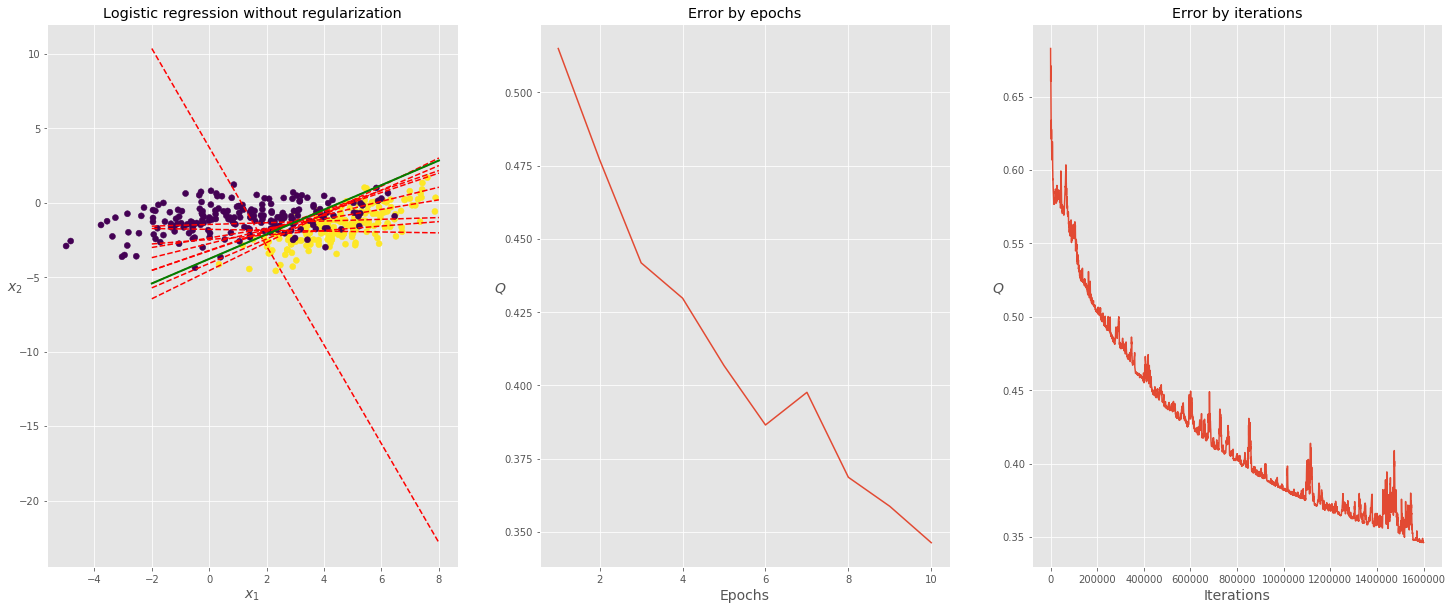

In [372]:
draw_graph(X, w_nan, w_list_nan, error_epoch_list_nan, error_iter_list_nan, 'Logistic regression without regularization')

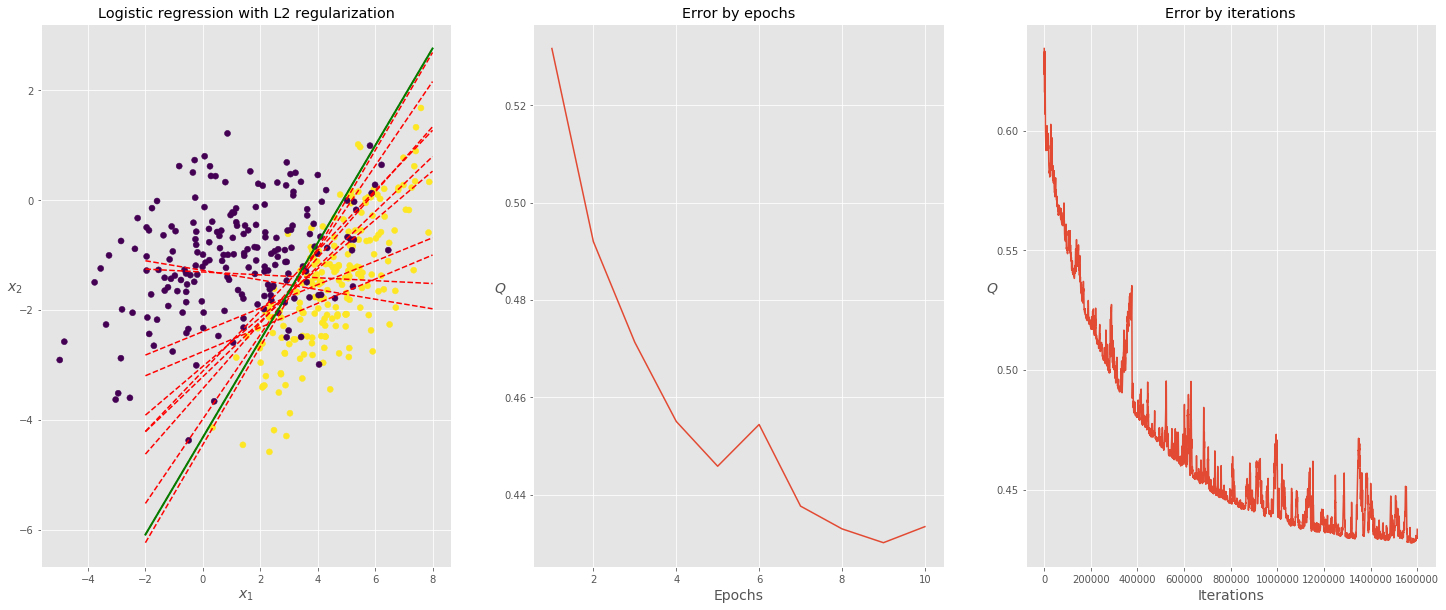

In [373]:
draw_graph(X, w_L2, w_list_L2, error_epoch_list_L2, error_iter_list_L2, 'Logistic regression with L2 regularization')

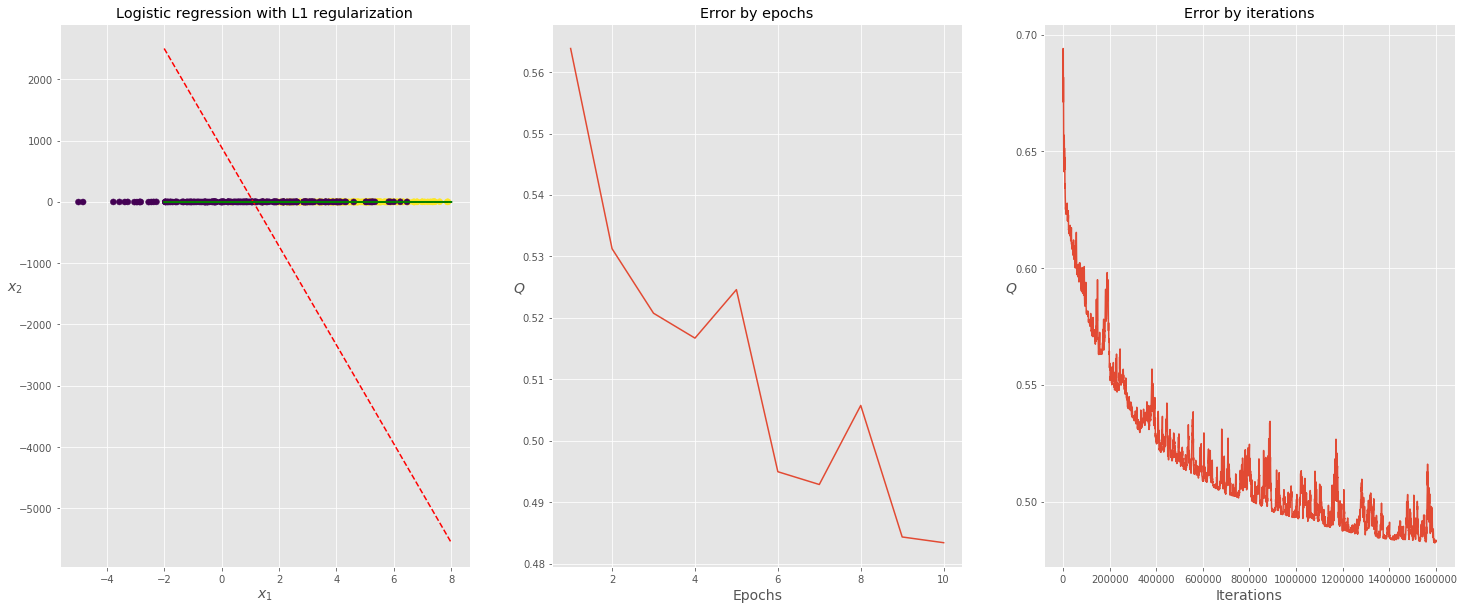

In [374]:
draw_graph(X, w_L1, w_list_L1, error_epoch_list_L1, error_iter_list_L1, 'Logistic regression with L1 regularization')

In [375]:
test = np.array([0 , -5])
print ('Логистическая регрессия без регуляризации')
print ('Вероятность классов: {}'.format(model.predict_proba(test)))
print ('Класс: {}'.format(model.predict(test)))
print ('Логистическая регрессия с L2 регуляризацией')
print ('Вероятность классов: {}'.format(modelL2.predict_proba(test)))
print ('Класс: {}'.format(modelL2.predict(test)))
print ('Логистическая регрессия с L1 регуляризацией')
print ('Вероятность классов: {}'.format(modelL1.predict_proba(test)))
print ('Класс: {}'.format(modelL1.predict(test)))

Логистическая регрессия без регуляризации
Вероятность классов: (0.56573173106021113, 0.43426826893978887)
Класс: 1
Логистическая регрессия с L2 регуляризацией
Вероятность классов: (0.51510608608773956, 0.48489391391226044)
Класс: 1
Логистическая регрессия с L1 регуляризацией
Вероятность классов: (0.20153571408403714, 0.79846428591596286)
Класс: 0


## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [376]:
range_alpha = np.linspace(0.5, 0.001, num=3)
max_epoch = 10
errors_nan = list()
errors_L1 = list()
errors_L2 = list()
for alpha in range_alpha:
    model = MySGDClassifier(C=.1, alpha=alpha, max_epoch=max_epoch)
    w, w_list, error_epoch_list, error_iter_list = model.fit(X, y, err_by_iter = False)
    errors_nan.append(error_epoch_list)
    modelL1 = MySGDClassifier(C=.1, alpha=alpha, max_epoch=max_epoch)
    w, w_list, error_epoch_list, error_iter_list = model.fit(X, y, regul='L1', err_by_iter = False)
    errors_L1.append(error_epoch_list)    
    modelL2 = MySGDClassifier(C=.1, alpha=alpha, max_epoch=max_epoch)
    w, w_list, error_epoch_list, error_iter_list = model.fit(X, y, regul='L2', err_by_iter = False)
    errors_L2.append(error_epoch_list)        

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


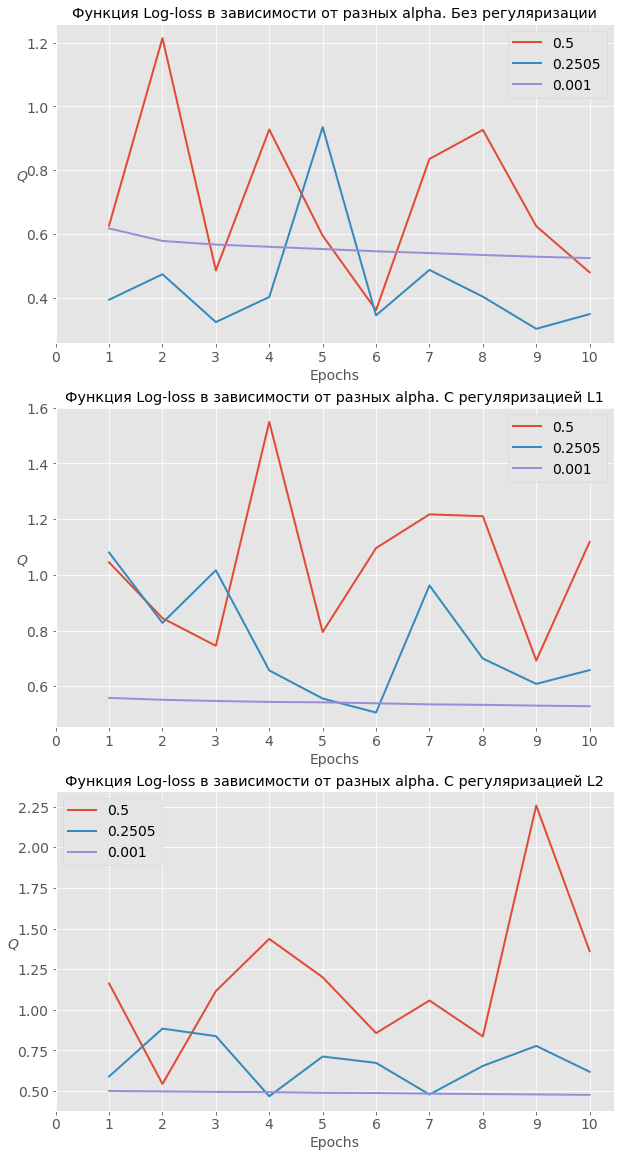

In [377]:
plt.figure(figsize=(10,20))
for i in range(0, len(errors_nan)):
    plt.subplot(311)
    plt.plot(np.linspace(1, max_epoch, num=10), errors_nan[i], linewidth=2)
    plt.legend(range_alpha, fontsize=14)
    plt.title('Функция Log-loss в зависимости от разных alpha. Без регуляризации')
    plt.xlabel("Epochs", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14)     
    plt.xticks(np.arange(11), fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplot(312)
    plt.plot(np.linspace(1, max_epoch, num=10), errors_L1[i], linewidth=2)
    plt.legend(range_alpha, fontsize=14)
    plt.title('Функция Log-loss в зависимости от разных alpha. С регуляризацией L1')
    plt.xlabel("Epochs", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14)     
    plt.xticks(np.arange(11), fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplot(313)
    plt.plot(np.linspace(1, max_epoch, num=10), errors_L2[i], linewidth=2)
    plt.legend(range_alpha, fontsize=14)
    plt.title('Функция Log-loss в зависимости от разных alpha. С регуляризацией L2')
    plt.xlabel("Epochs", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14)     
    plt.xticks(np.arange(11), fontsize=14)
    plt.yticks(fontsize=14)    
plt.show()